In [1]:
from __future__ import annotations

import argparse
import importlib
import logging
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import mplhep as hep

hep.style.use("CMS")

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

import HH4b.utils as utils
from HH4b import hh_vars
from HH4b.log_utils import log_config
from HH4b.plotting import multiROCCurveGrey
from HH4b.utils import get_var_mapping

In [7]:
def load_events_and_bdt(path_to_dir, year, jet_coll_pnet, jet_coll_mass, bdt_models):
    # logger.info(f"Load {year}")

    jet_collection = "bbFatJet"
    reorder_txbb = True
    txbb_str = "bbFatJet" + jet_coll_pnet
    mass_str = "bbFatJet" + jet_coll_mass

    txbb_preselection = {
        "bbFatJetPNetTXbb": 0.3,
        "bbFatJetPNetTXbbLegacy": 0.8,
        "bbFatJetParTTXbb": 0.3,
    }
    msd1_preselection = {
        "bbFatJetPNetTXbb": 40,
        "bbFatJetPNetTXbbLegacy": 40,
        "bbFatJetParTTXbb": 40,
    }
    msd2_preselection = {
        "bbFatJetPNetTXbb": 30,
        "bbFatJetPNetTXbbLegacy": 0,
        "bbFatJetParTTXbb": 30,
    }

    sample_dirs = {
        year: {
            "qcd": [
                "QCD_HT-1000to1200",
                # "QCD_HT-1200to1500",
                # "QCD_HT-1500to2000",
                # "QCD_HT-2000",
                # "QCD_HT-400to600",
                # "QCD_HT-600to800",
                # "QCD_HT-800to1000",
            ],
            "ttbar": [
                "TTto4Q",
            ],
        },
    }
    sample_dirs_sig = {
        year: {
            "hh4b": [
                "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"
            ],  # the ? enforces exact matching
        }
    }
    # columns (or branches) to load: (branch_name, number of columns)
    # e.g. to load 2 jets ("ak8FatJetPt", 2)
    num_jets = 2

    # feature_columns = [ (feature,num_jets) for feature in features_to_plot]

    # TODO: review columns
    columns = [
        ("weight", 1),  # genweight * otherweights
        ("event", 1),
        ("MET_pt", 1),
        ("bbFatJetTau3OverTau2", 2),
        ("VBFJetPt", 2),
        ("VBFJetEta", 2),
        ("VBFJetPhi", 2),
        ("VBFJetMass", 2),
        ("AK4JetAwayPt", 2),
        ("AK4JetAwayEta", 2),
        ("AK4JetAwayPhi", 2),
        ("AK4JetAwayMass", 2),
        (f"{jet_collection}Pt", num_jets),
        (f"{jet_collection}Msd", num_jets),
        (f"{jet_collection}Eta", num_jets),
        (f"{jet_collection}Phi", num_jets),
        (f"{jet_collection}PNetPXbbLegacy", num_jets),  # Legacy PNet
        (f"{jet_collection}PNetPQCDbLegacy", num_jets),
        (f"{jet_collection}PNetPQCDbbLegacy", num_jets),
        (f"{jet_collection}PNetPQCD0HFLegacy", num_jets),
        (f"{jet_collection}PNetMassLegacy", num_jets),
        (f"{jet_collection}PNetTXbbLegacy", num_jets),
        (f"{jet_collection}PNetTXbb", num_jets),  # 103X PNet
        (f"{jet_collection}PNetMass", num_jets),
        (f"{jet_collection}PNetQCD0HF", num_jets),
        (f"{jet_collection}PNetQCD1HF", num_jets),
        (f"{jet_collection}PNetQCD2HF", num_jets),
        (f"{jet_collection}ParTmassVis", num_jets),  # GloParT
        (f"{jet_collection}ParTTXbb", num_jets),
        (f"{jet_collection}ParTPXbb", num_jets),
        (f"{jet_collection}ParTPQCD0HF", num_jets),
        (f"{jet_collection}ParTPQCD1HF", num_jets),
        (f"{jet_collection}ParTPQCD2HF", num_jets),
    ]
    signal_exclusive_columns = []

    # columns = columns + feature_columns

    # selection to apply
    filters = [
        [
            (f"('{jet_collection}Pt', '0')", ">=", 250),
            (f"('{jet_collection}Pt', '1')", ">=", 250),
        ],
    ]

    def apply_cuts(events_dict, txbb_str, mass_str):
        for key in events_dict:

            # TODO: add BDT cut here

            msd1 = events_dict[key]["bbFatJetMsd"][0]
            msd2 = events_dict[key]["bbFatJetMsd"][1]
            pt1 = events_dict[key]["bbFatJetPt"][0]
            pt2 = events_dict[key]["bbFatJetPt"][1]
            txbb1 = events_dict[key][txbb_str][0]
            mass1 = events_dict[key][mass_str][0]
            mass2 = events_dict[key][mass_str][1]
            # add msd > 40 cut for the first jet FIXME: replace this by the trigobj matched jet
            events_dict[key] = events_dict[key][
                (pt1 > 250)
                & (pt2 > 250)
                & (txbb1 > txbb_preselection[txbb_str])
                & (msd1 > msd1_preselection[txbb_str])
                & (msd2 > msd2_preselection[txbb_str])
                & (mass1 > 50)
                & (mass2 > 50)
            ].copy()

        return events_dict

    # dictionary that will contain all information (from all samples)
    events_dict = {
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(
            path_to_dir,
            sample_dirs_sig[year],
            year,
            filters=filters,
            columns=utils.format_columns(columns + signal_exclusive_columns),
            reorder_txbb=reorder_txbb,
            txbb_str=txbb_str,
            variations=False,
        ),
        **utils.load_samples(
            path_to_dir,  # input directory
            sample_dirs[year],  # process_name: datasets
            year,  # year (to find corresponding luminosity)
            filters=filters,  # do not apply filter
            columns=utils.format_columns(
                columns
            ),  # columns to load from parquet (to not load all columns), IMPORTANT columns must be formatted: ("column name", "idx")
            reorder_txbb=reorder_txbb,  # whether to reorder bbFatJet collection
            txbb_str=txbb_str,
            variations=False,  # do not load systematic variations of weights
        ),
    }

    def get_bdt(events_dict, bdt_model, bdt_model_name, bdt_config, jlabel=""):
        bdt_model = xgb.XGBClassifier()
        bdt_model.load_model(
            fname=f"../boosted/bdt_trainings_run3/{bdt_model_name}/trained_bdt.model"
        )
        make_bdt_dataframe = importlib.import_module(
            f".{bdt_config}", package="HH4b.boosted.bdt_trainings_run3"
        )
        bdt_events = make_bdt_dataframe.bdt_dataframe(events_dict, get_var_mapping(jlabel))
        preds = bdt_model.predict_proba(bdt_events)

        bdt_score = None
        bdt_score_vbf = None
        if preds.shape[1] == 2:  # binary BDT only
            bdt_score = preds[:, 1]
        elif preds.shape[1] == 3:  # multi-class BDT with ggF HH, QCD, ttbar classes
            bdt_score = preds[:, 0]  # ggF HH
        elif preds.shape[1] == 4:  # multi-class BDT with ggF HH, VBF HH, QCD, ttbar classes
            bg_tot = np.sum(preds[:, 2:], axis=1)
            bdt_score = preds[:, 0] / (preds[:, 0] + bg_tot)
            bdt_score_vbf = preds[:, 1] / (preds[:, 1] + preds[:, 2] + preds[:, 3])

        print(len(bdt_score))
        print(len(bdt_score_vbf))
        print(bdt_events.shape[0])
        return bdt_score, bdt_score_vbf, bdt_events

    events_dict = apply_cuts(events_dict, txbb_str, mass_str)

    bdt_scores = []
    bdt_score_list = []
    bdt_score_vbf_list = []
    bdt_df_list = []
    for bdt_model in bdt_models:
        # logger.info(f"Perform inference {bdt_model}")
        bdt_config = bdt_models[bdt_model]["config"]
        bdt_model_name = bdt_models[bdt_model]["model_name"]
        for key in events_dict:
            bdt_score, bdt_score_vbf, bdt_df = get_bdt(
                events_dict[key], bdt_model, bdt_model_name, bdt_config
            )

            events_dict[key][f"bdtscore_{bdt_model}"] = (
                bdt_score if bdt_score is not None else np.ones(events_dict[key]["weight"])
            )
            events_dict[key][f"bdtscoreVBF_{bdt_model}"] = (
                bdt_score if bdt_score is not None else np.ones(events_dict[key]["weight"])
            )
            bdt_scores.extend([f"bdtscore_{bdt_model}", f"bdtscoreVBF_{bdt_model}"])
            bdt_score_list.append(bdt_score)
            bdt_score_vbf_list.append(bdt_score_vbf)
            bdt_df_list.append(bdt_df)

    # Combine all bdt_df from each key as one df
    bdt_score = np.concatenate(bdt_score_list)
    bdt_score_vbf = np.concatenate(bdt_score_vbf_list)
    bdt_df = pd.concat(bdt_df_list, ignore_index=True)
    # print(bdt_df)
    # Add finalWeight to the list of columns being retained
    bdt_scores.append("finalWeight")
    bdt_score_dict = {key: events_dict[key][bdt_scores] for key in events_dict}
    # return events_dict, bdt_score_dict, bdt_df
    return bdt_score, bdt_score_vbf, bdt_df

In [12]:
"""
Plot BDT Inputs

#TODO: add description of the function

"""


def plot_bdt_features(bdt_score, bdt_score_vbf, bdt_df):

    # Define the BDT cut thresholds
    bdt_cuts = [0.03, 0.88, 0.98]

    # Define colors and labels for each histogram, including before any cut
    colors = ["black", "blue", "green", "red"]  # Adjust colors as needed
    labels = ["Before BDT Cut", "BDT Cut > 0.03", "BDT Cut > 0.88", "BDT Cut > 0.98"]

    # Create boolean masks for each BDT cut
    bdt_masks = [np.ones(len(bdt_score), dtype=bool)]  # Initial mask: all True (no cut)
    for cut in bdt_cuts:
        bdt_masks.append(bdt_score > cut)

    bdt_masks_vbf = [np.ones(len(bdt_score_vbf), dtype=bool)]  # Initial mask: all True (no cut)
    for cut in bdt_cuts:
        bdt_masks_vbf.append(bdt_score_vbf > cut)

    # Filter the columns to exclude those containing "VBF"
    columns_to_plot = [col for col in bdt_df.columns if "VBF" not in col]

    # Loop over each feature in the DataFrame
    # currently plots only ggF
    for column in bdt_df.columns:
        plt.figure(figsize=(12, 6))

        # Prepare data for each histogram
        hists = []
        edges = None
        for i, mask in enumerate(bdt_masks):
            data = bdt_df.loc[mask, column]
            counts, bins = np.histogram(data, bins=50)
            hists.append(counts)
            if edges is None:
                edges = bins

        # Plot the histograms
        hep.histplot(
            hists, edges, stack=False, histtype="step", label=labels, color=colors, linewidth=1.5
        )

        plt.title(f"Distribution of {column} (ggF only)")
        plt.xlabel(column)
        plt.ylabel("Events")
        plt.legend()
        plt.grid(True)
        plt.show()

50377
50377
50377
105009
105009
105009
701455
701455
701455
Index(['HHPt', 'HHeta', 'HHmass', 'MET', 'H1T32', 'H2T32', 'H1Mass', 'H1Pt',
       'H2Pt', 'H1eta', 'H1Xbb', 'H1QCDb', 'H1QCDbb', 'H1QCDothers',
       'H1Pt_HHmass', 'H2Pt_HHmass', 'H1Pt/H2Pt', 'VBFjjMass', 'VBFjjDeltaEta',
       'H1AK4JetAway1dR', 'H2AK4JetAway2dR', 'H1AK4JetAway1mass',
       'H2AK4JetAway2mass'],
      dtype='object')


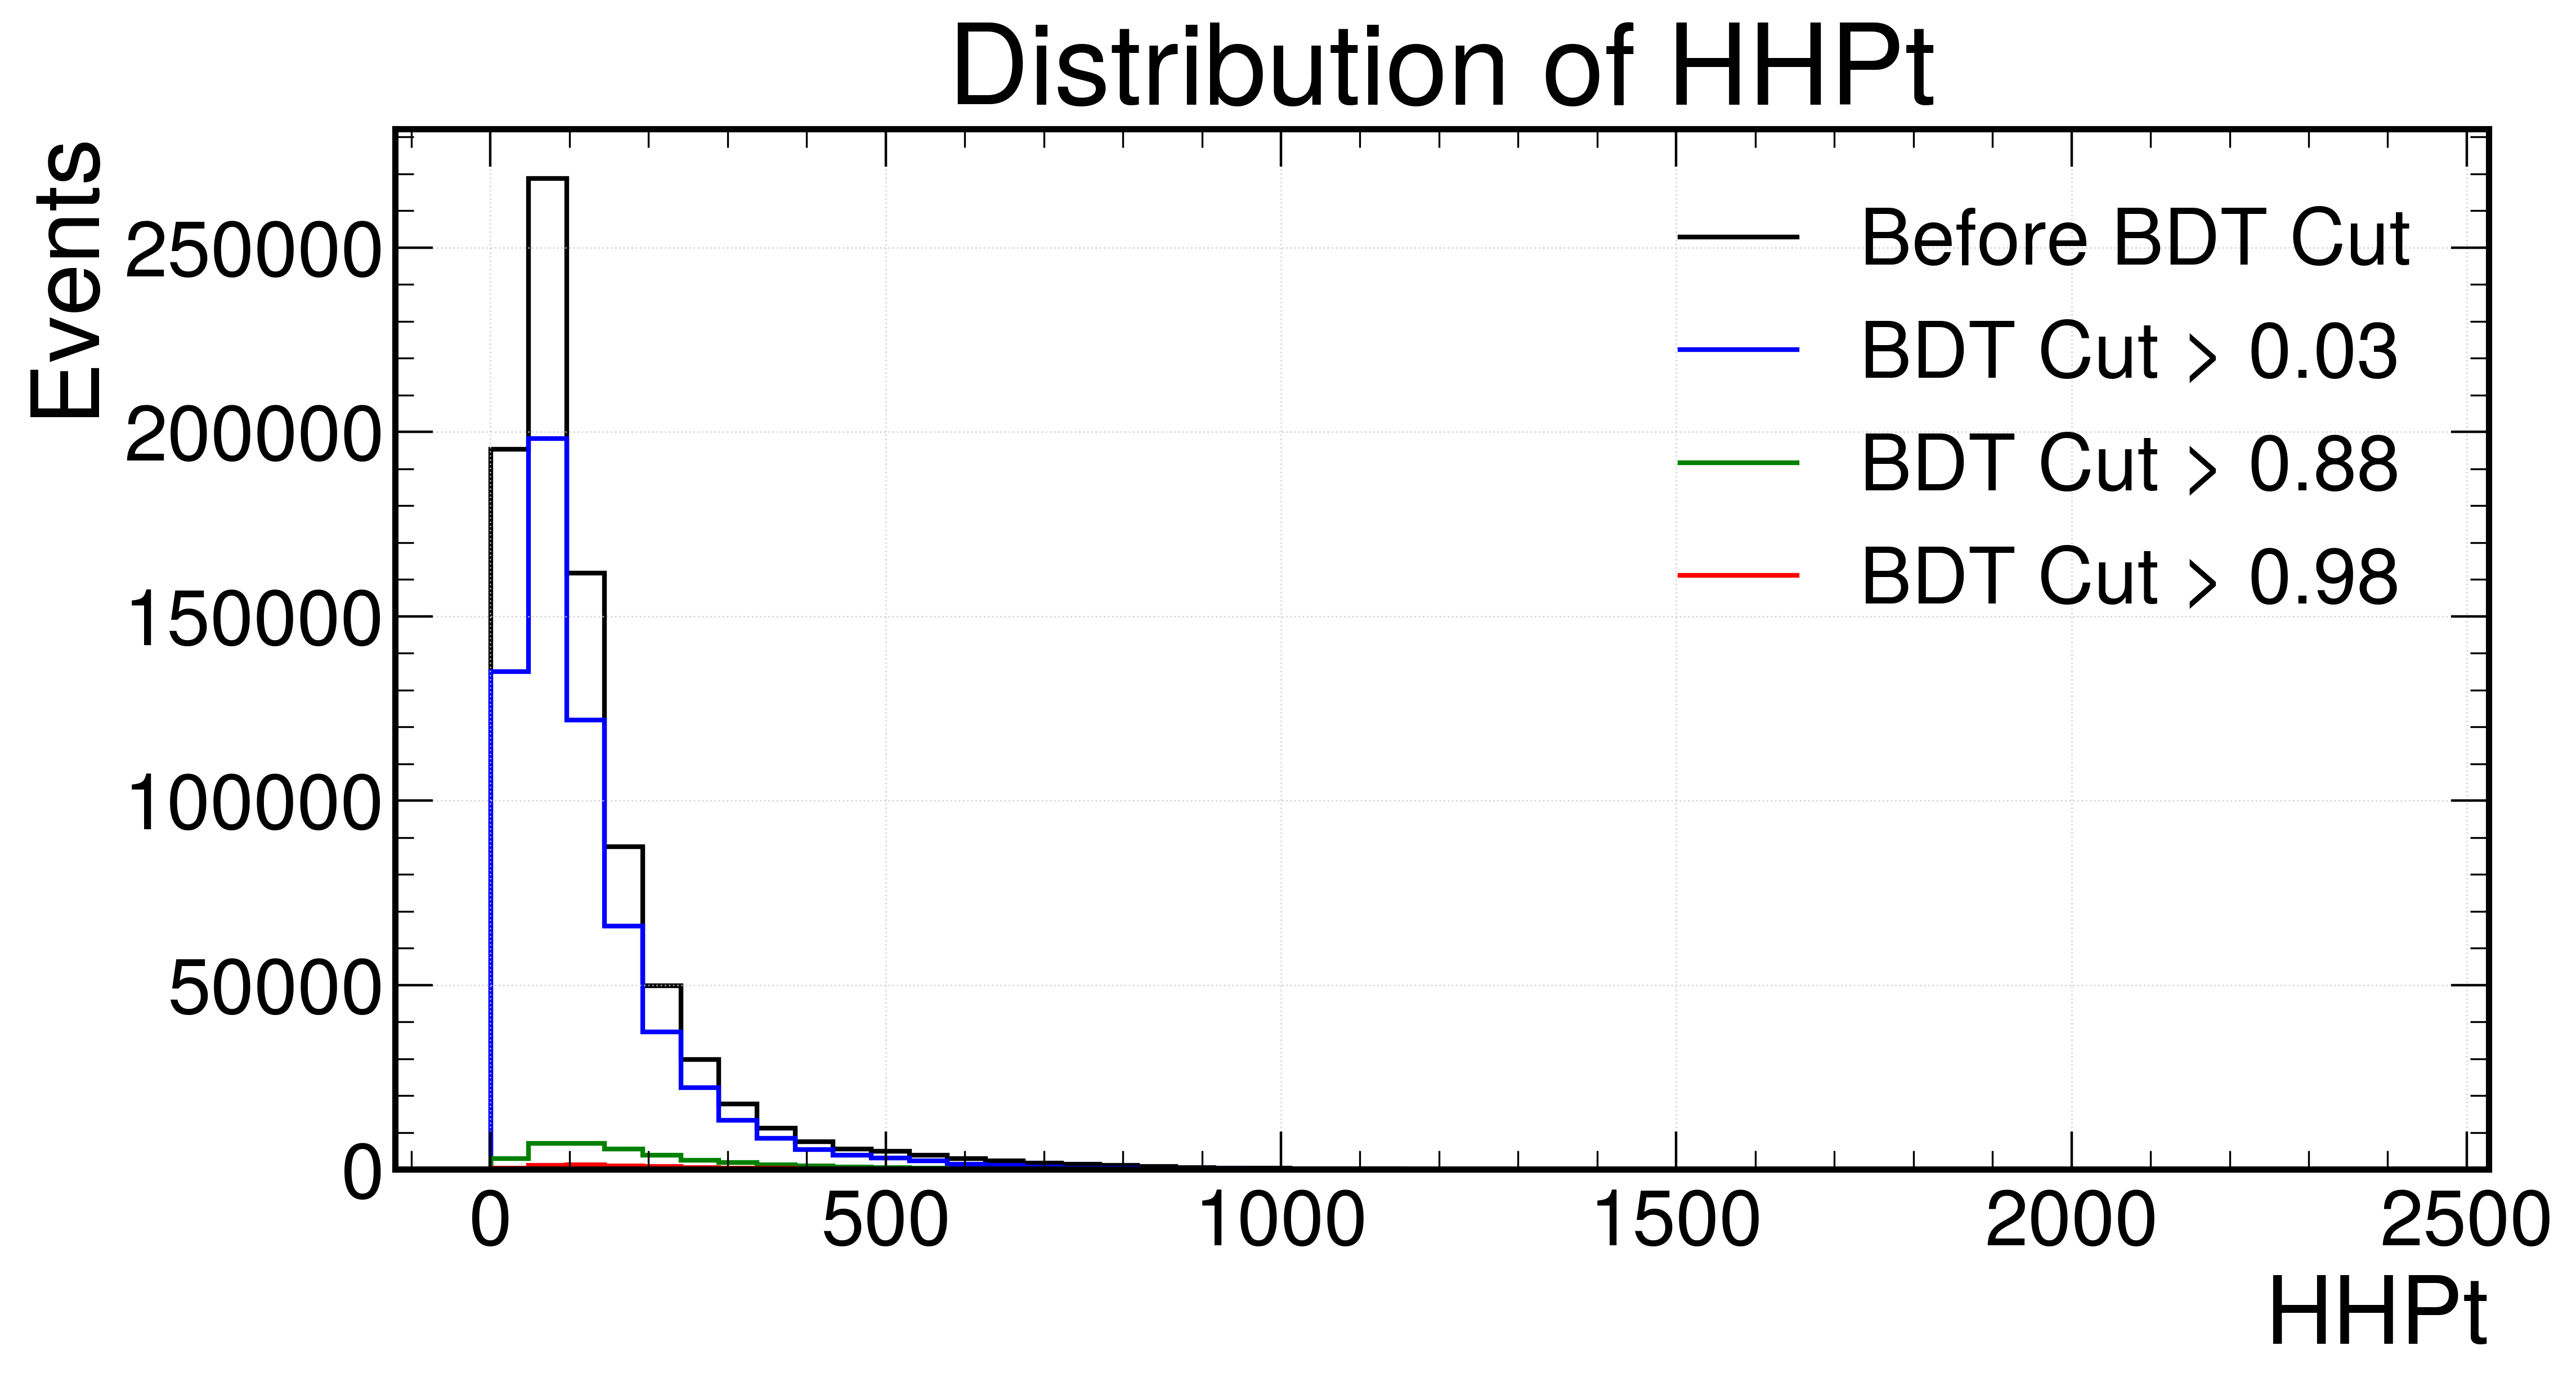

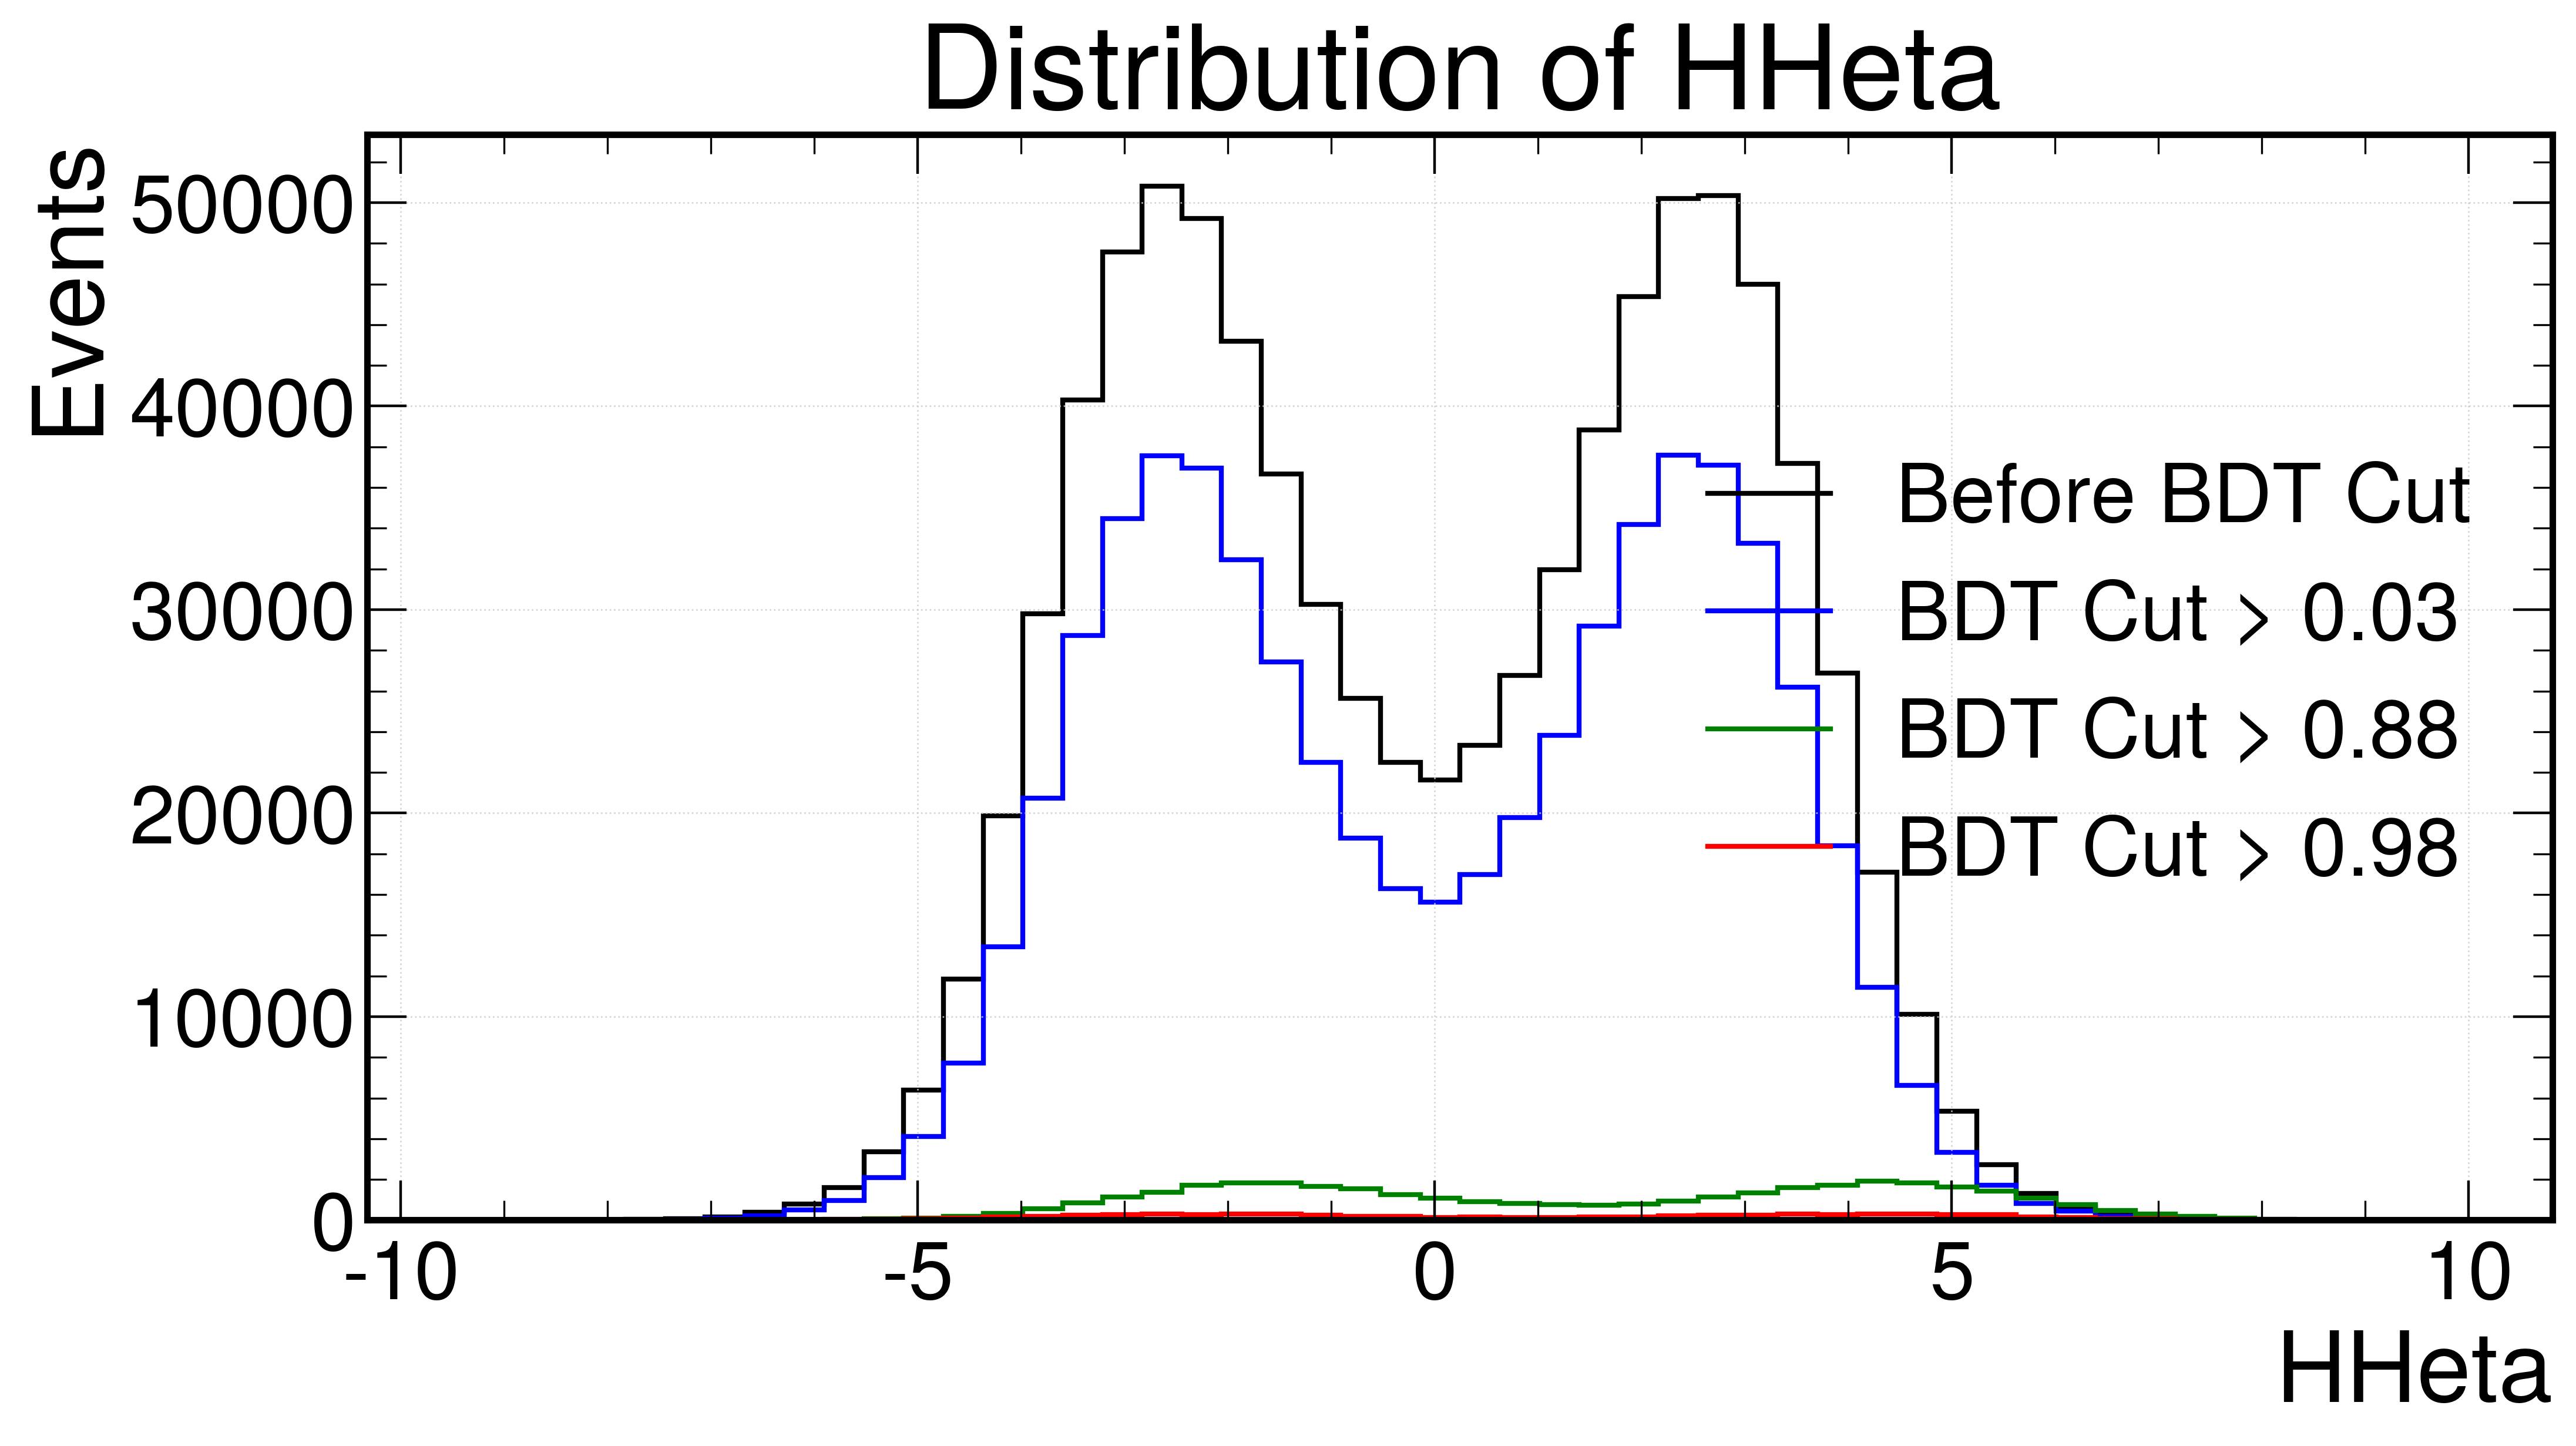

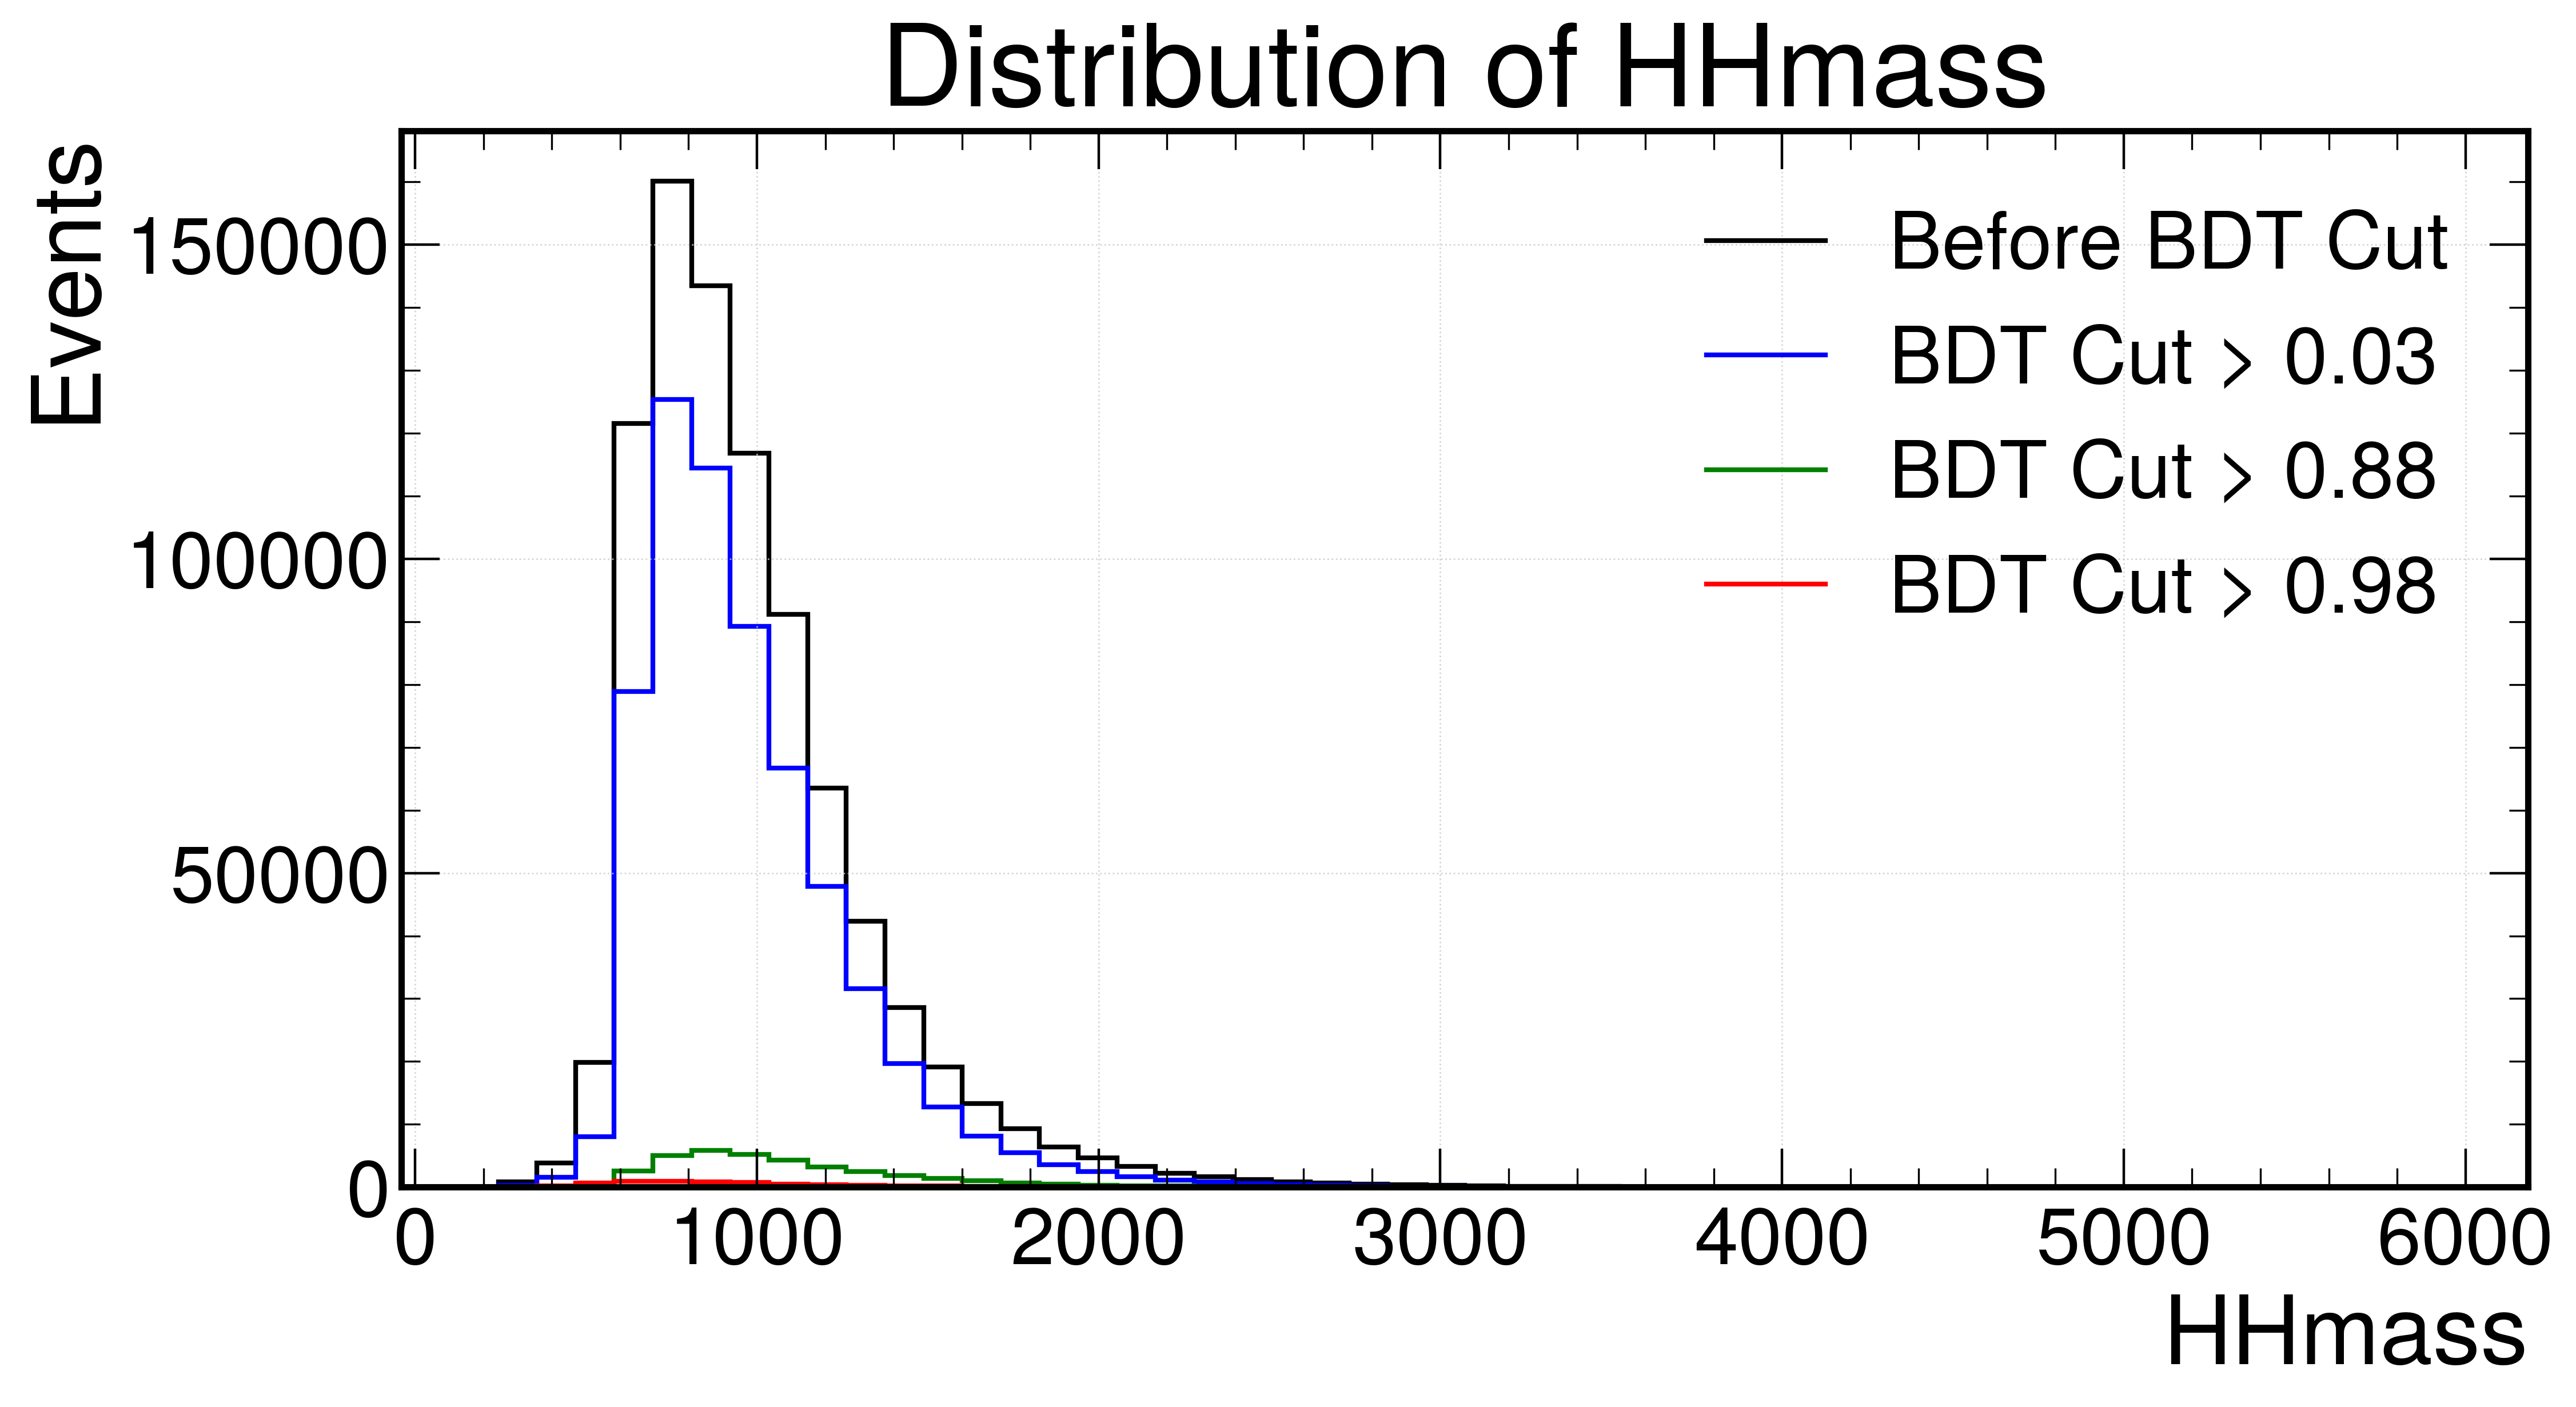

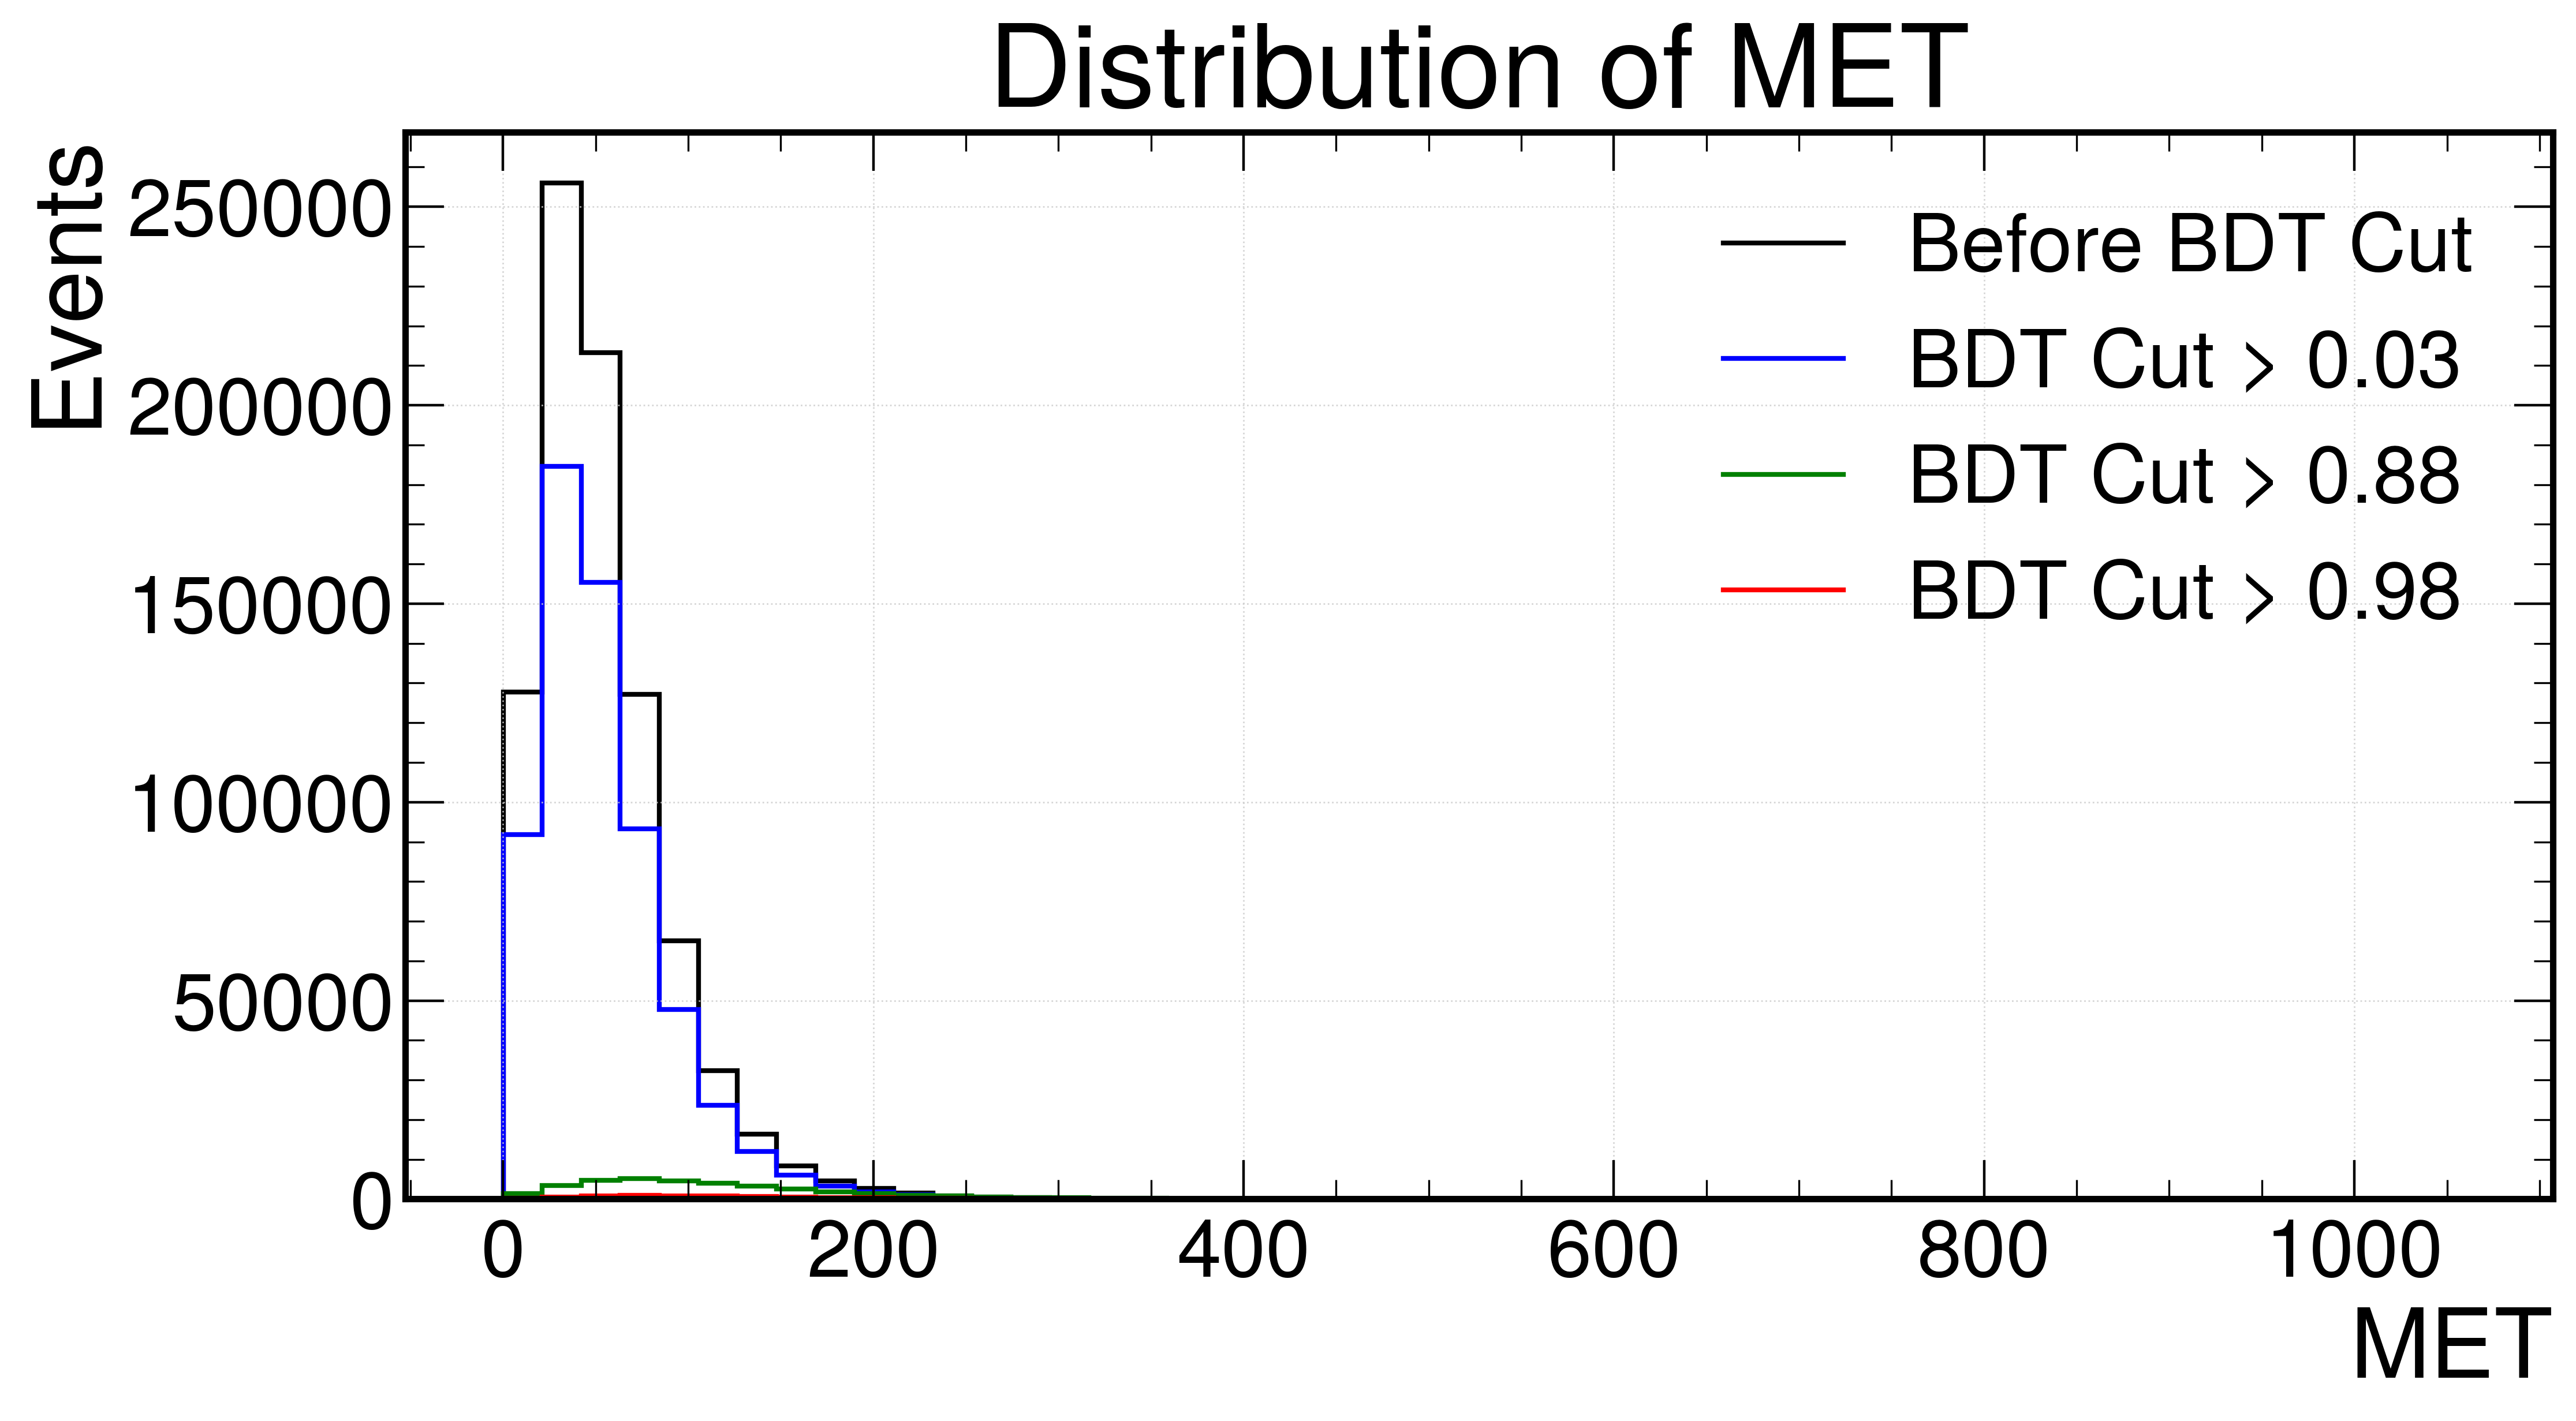

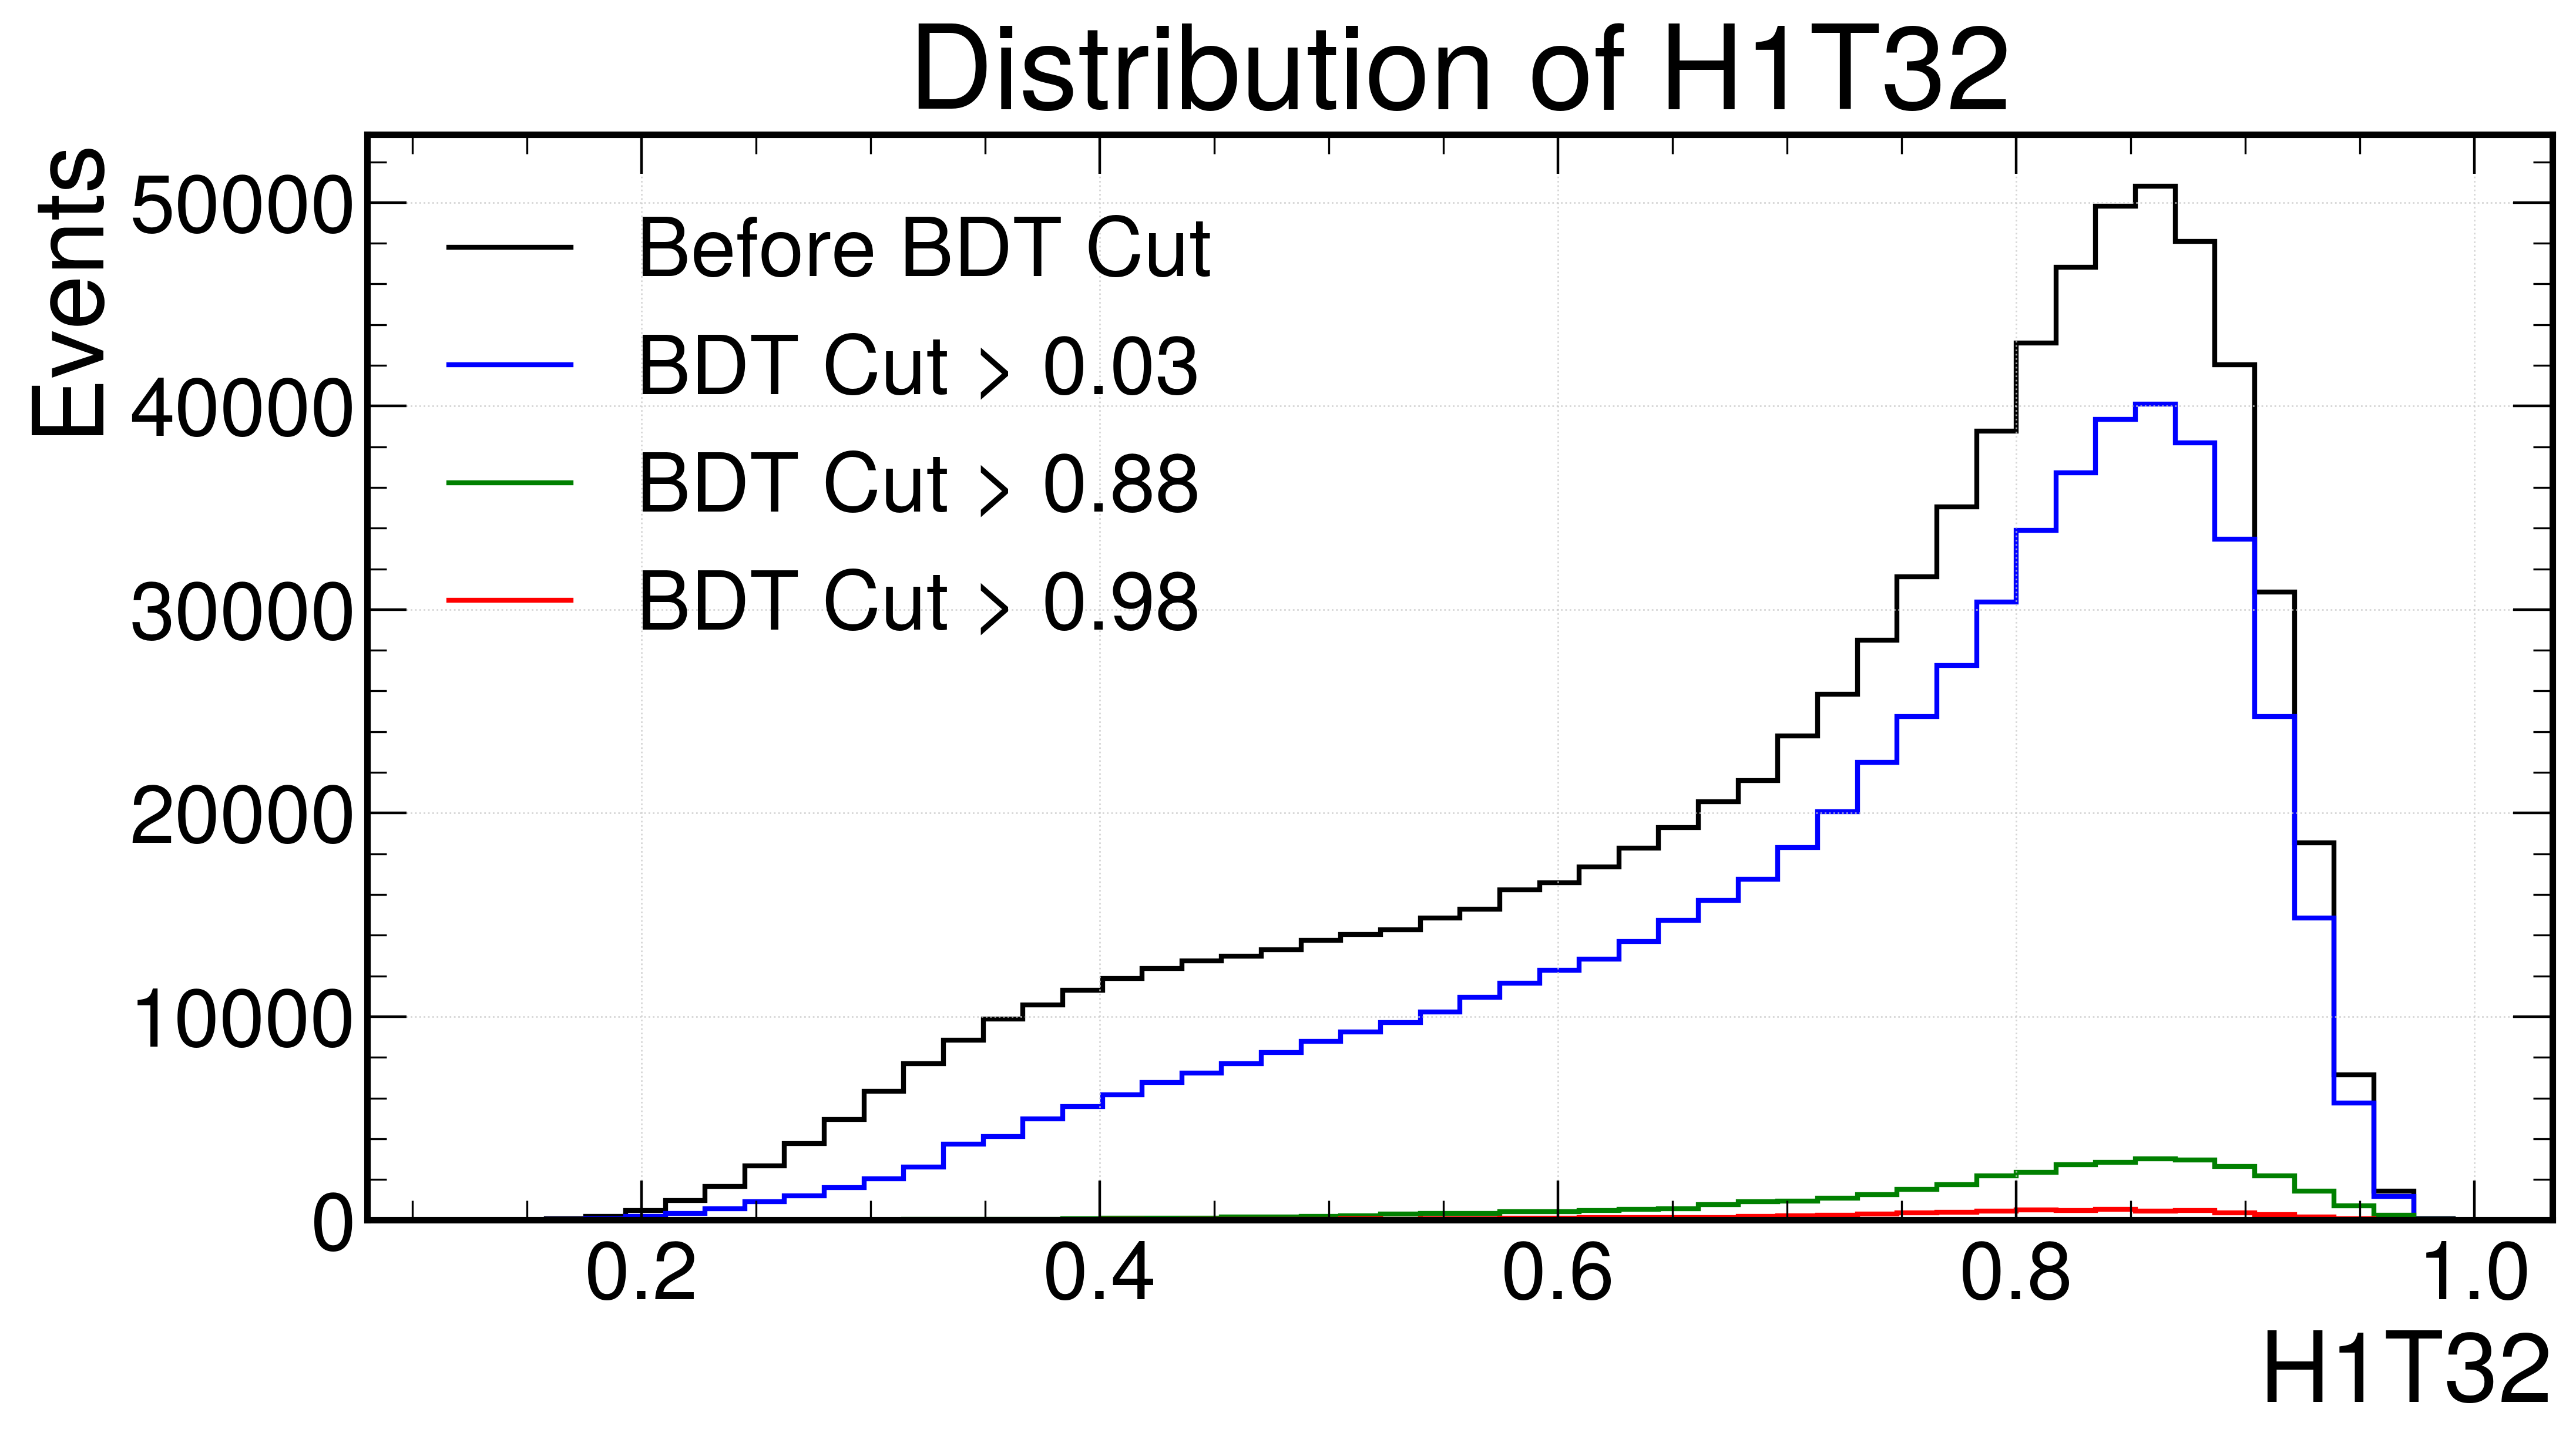

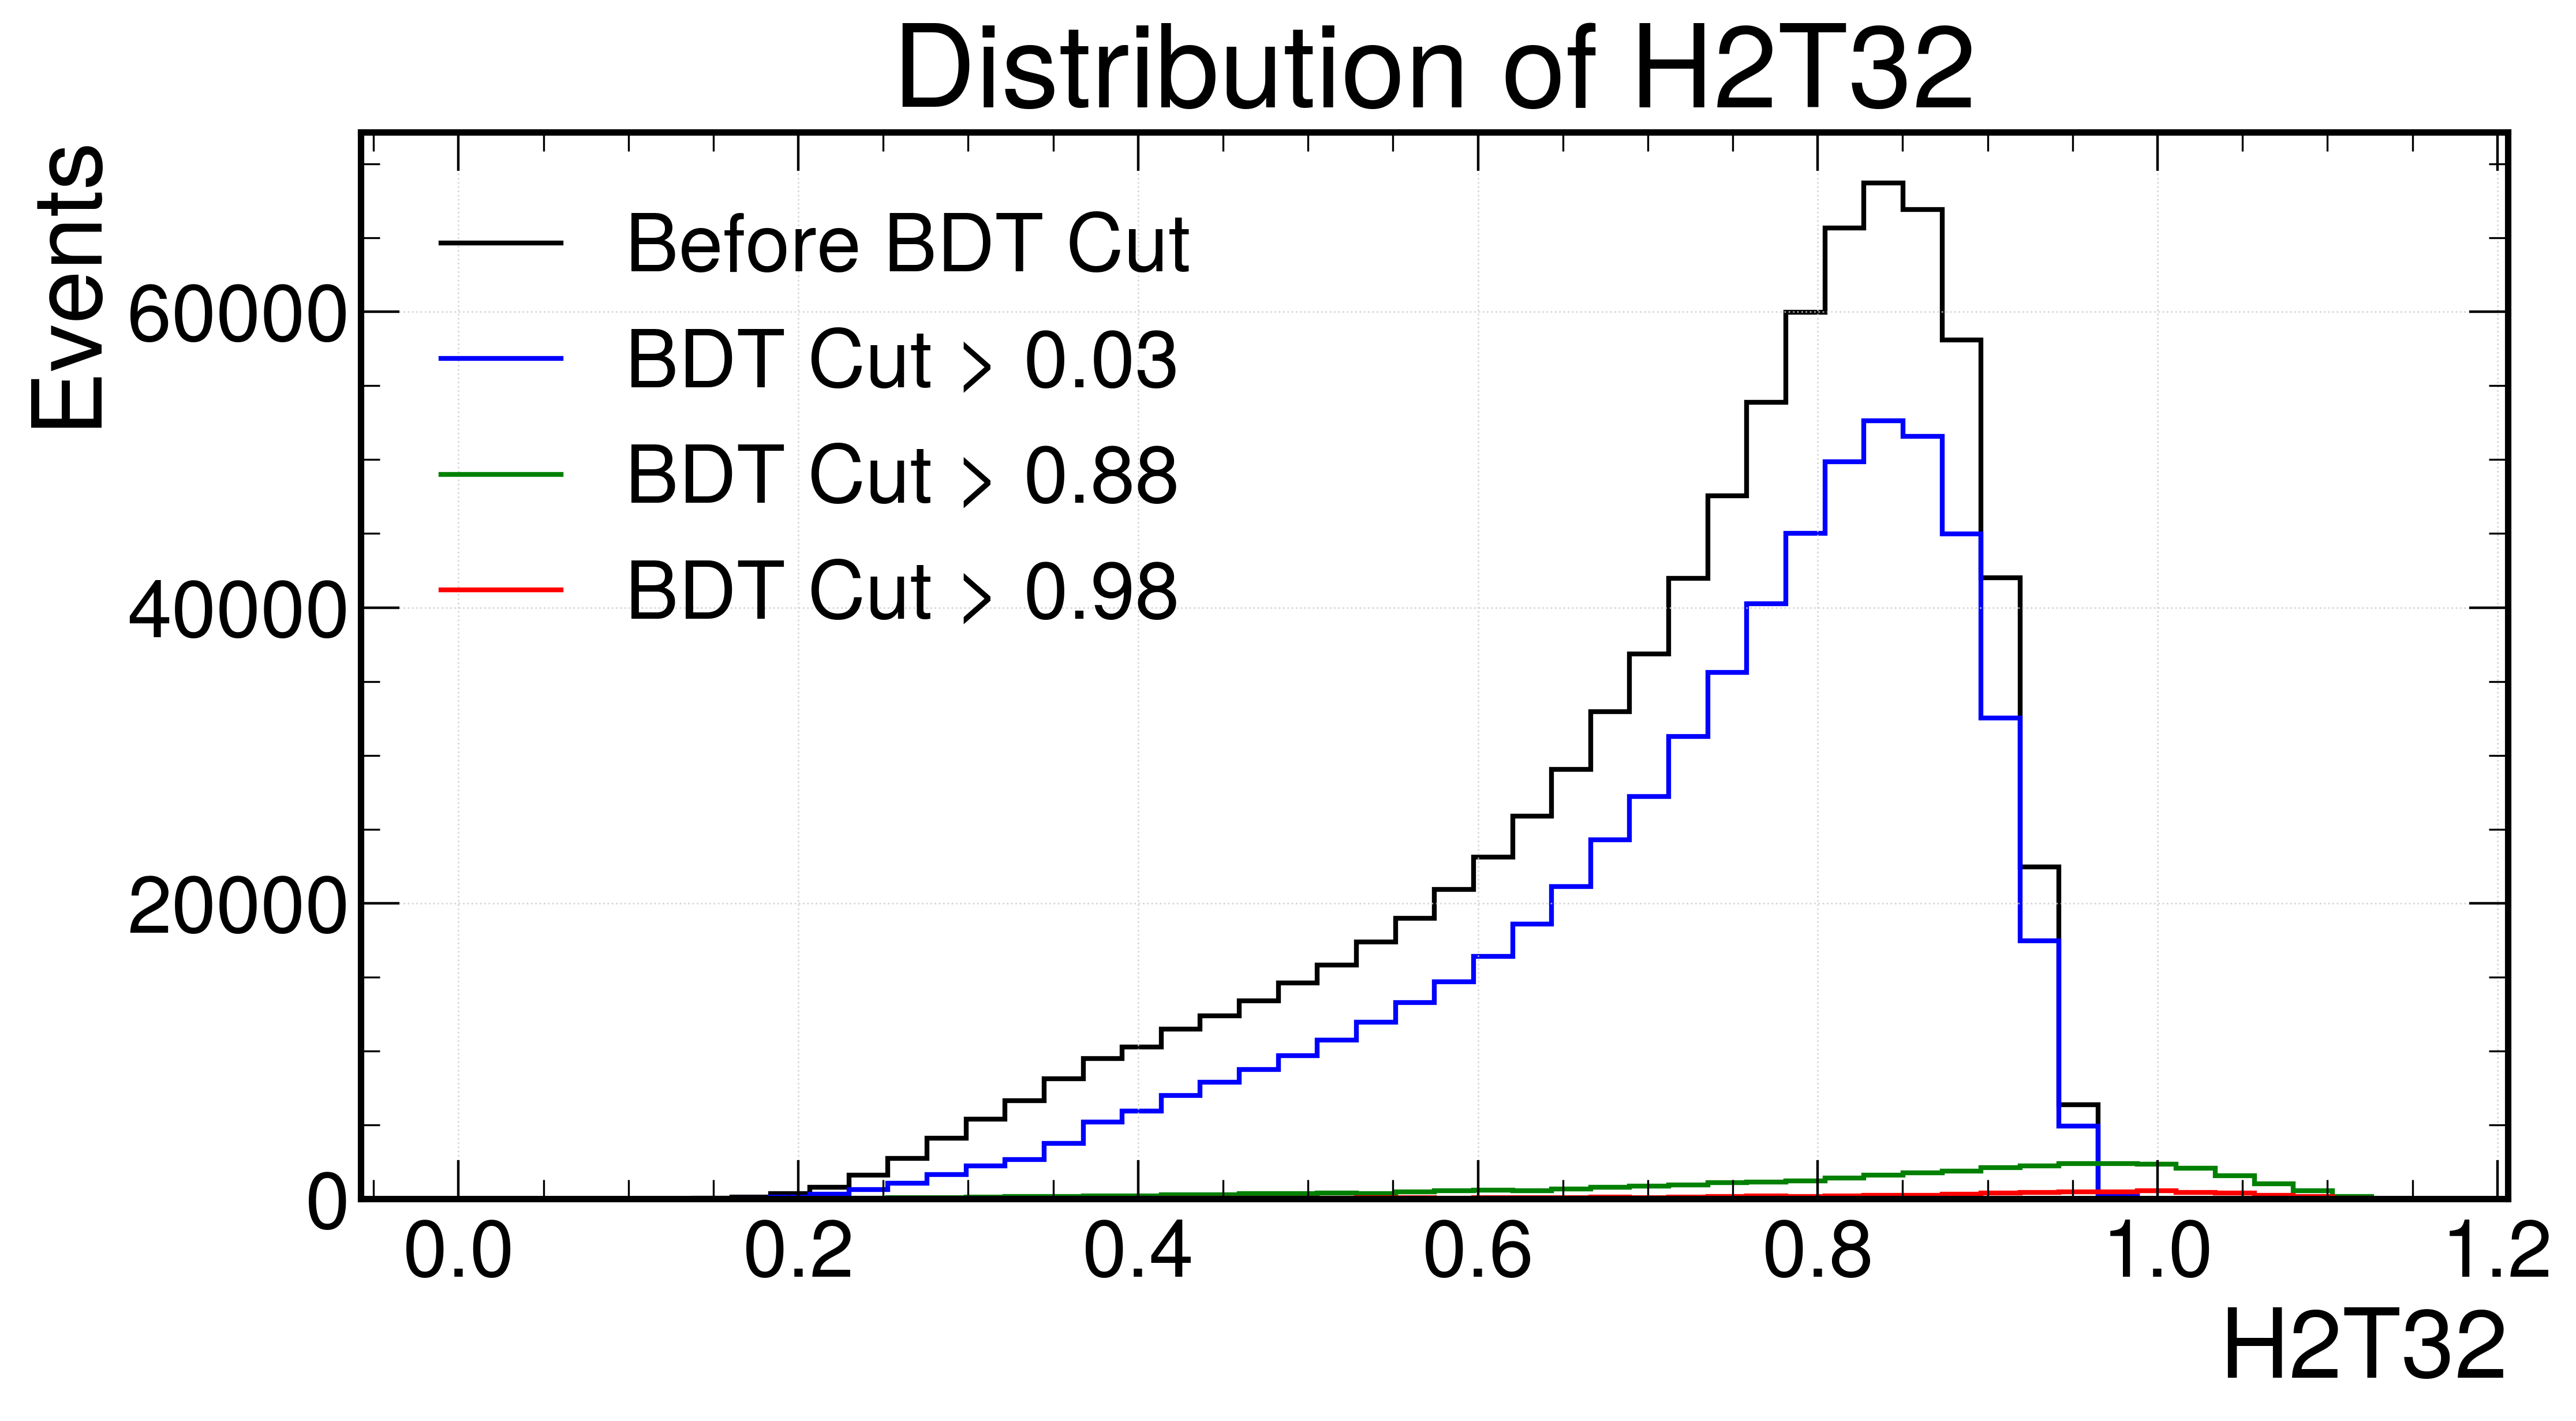

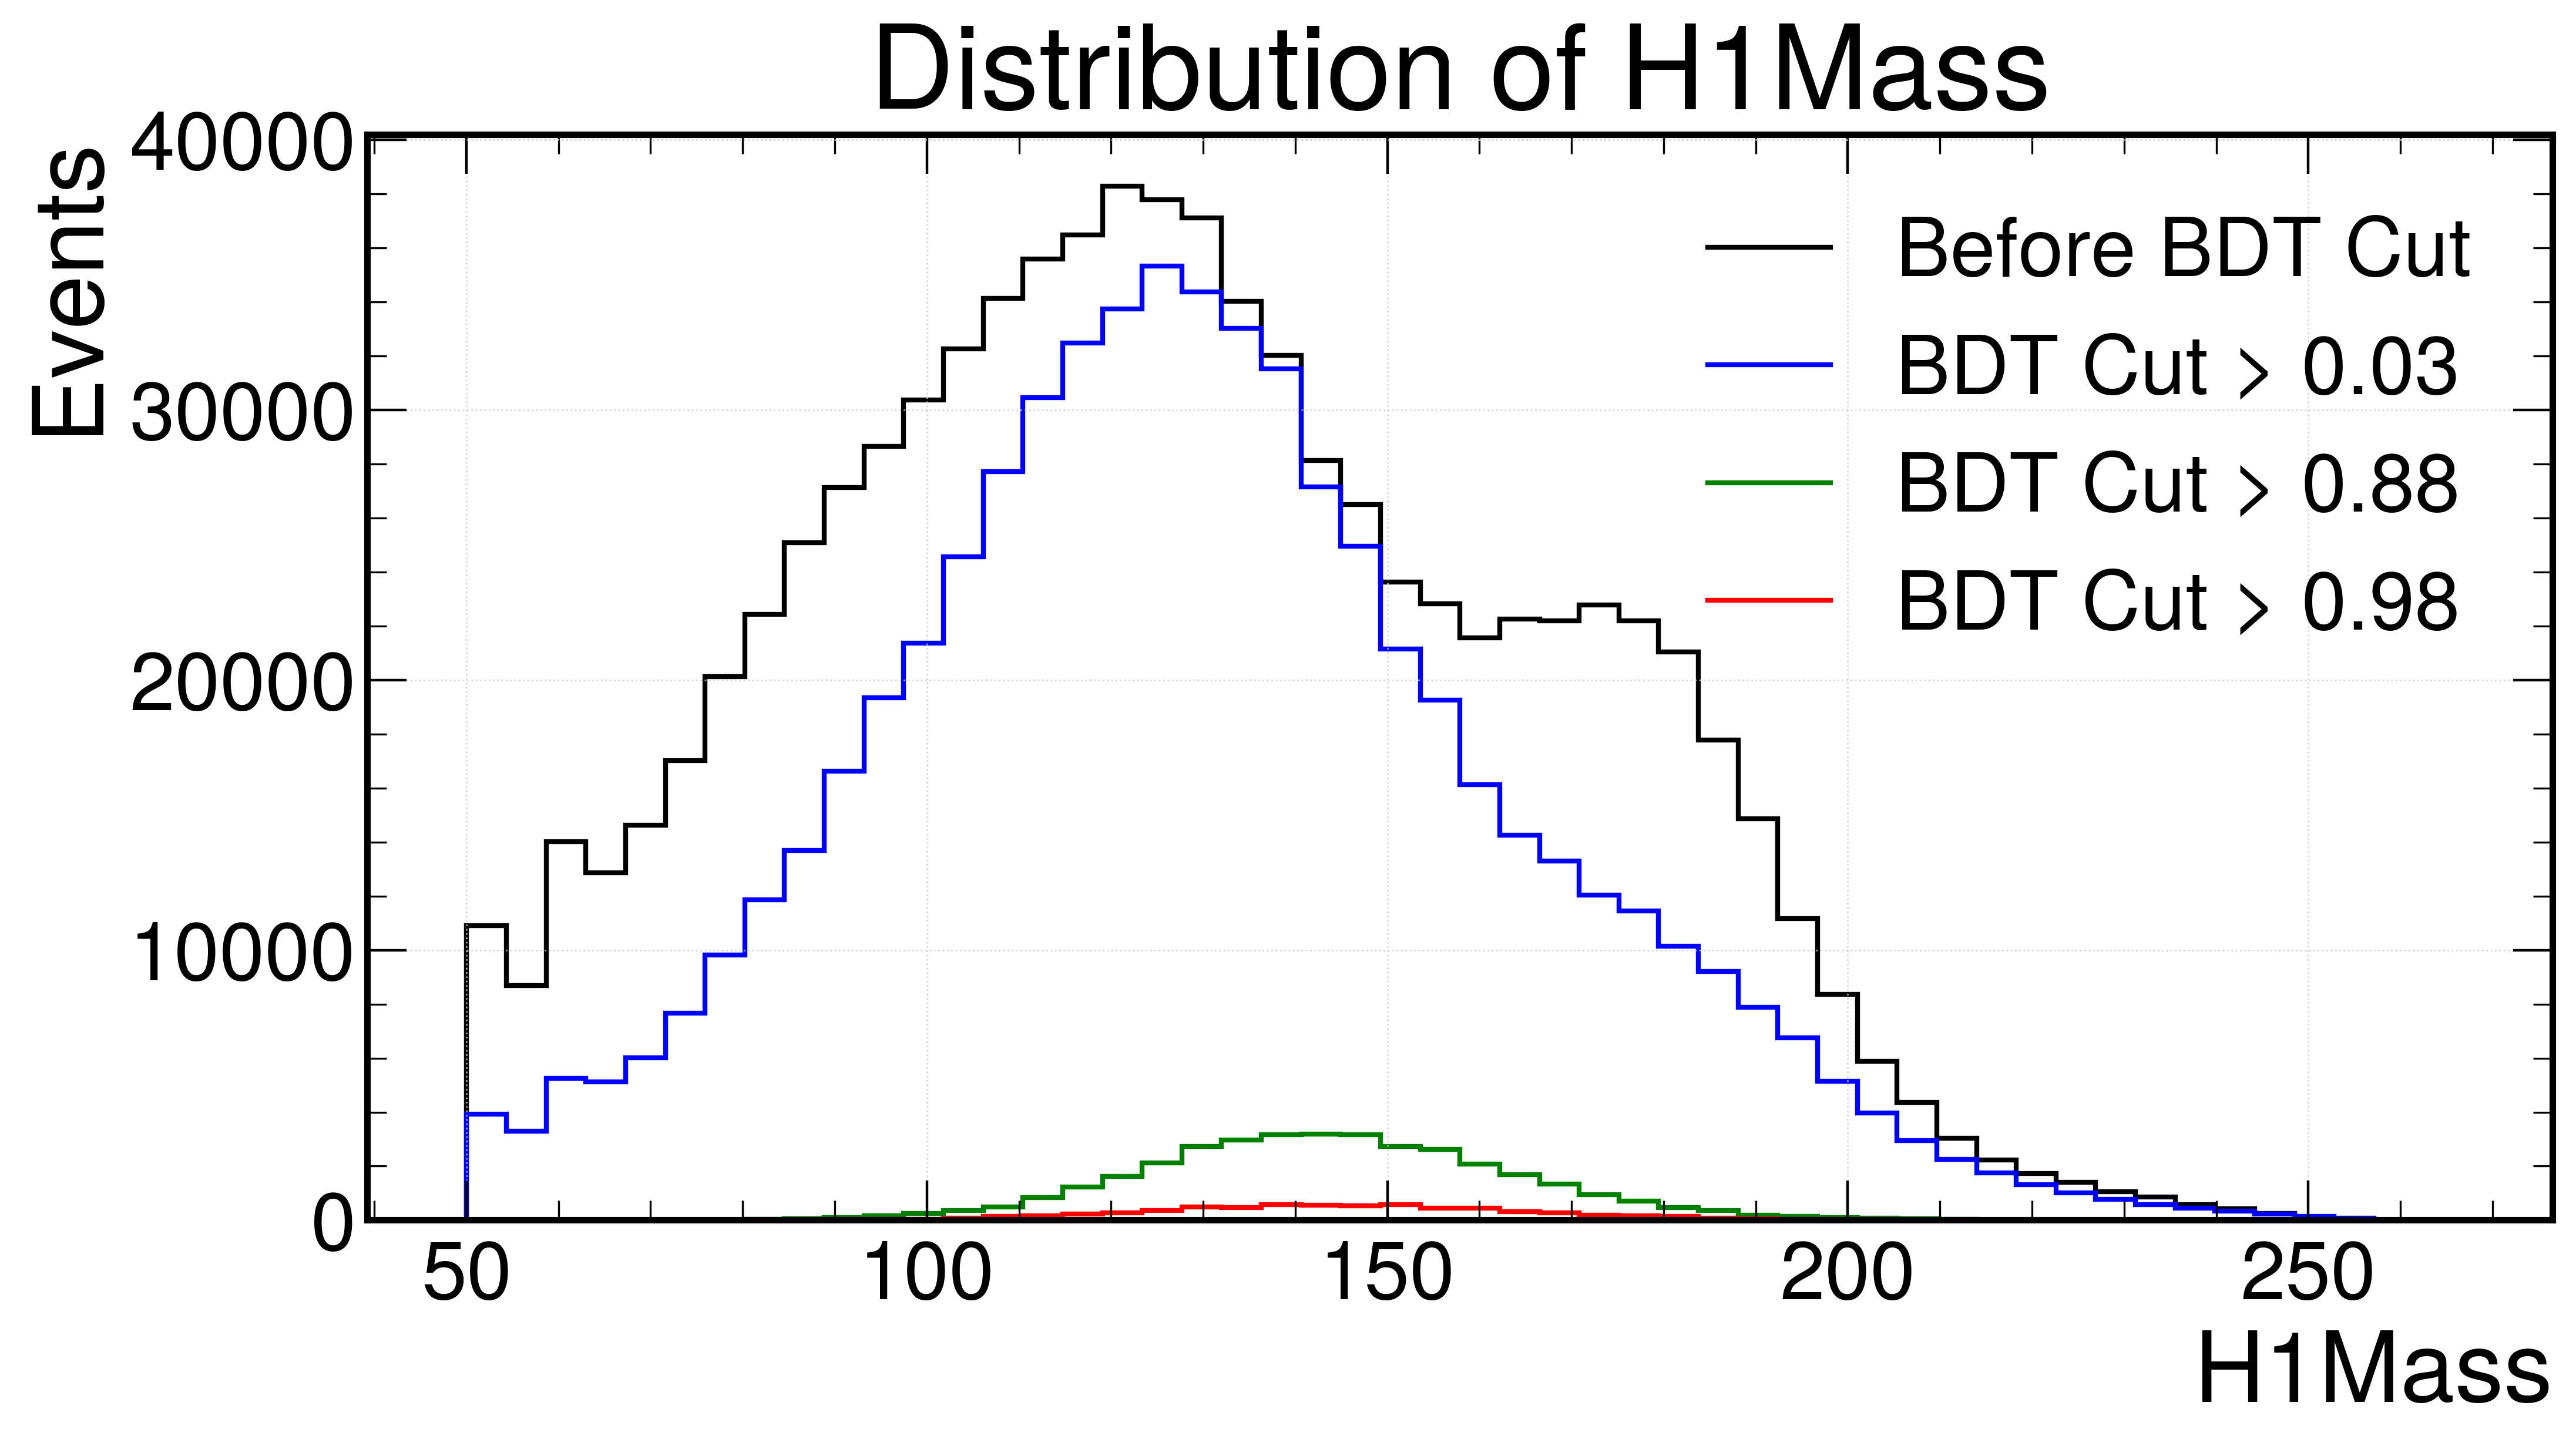

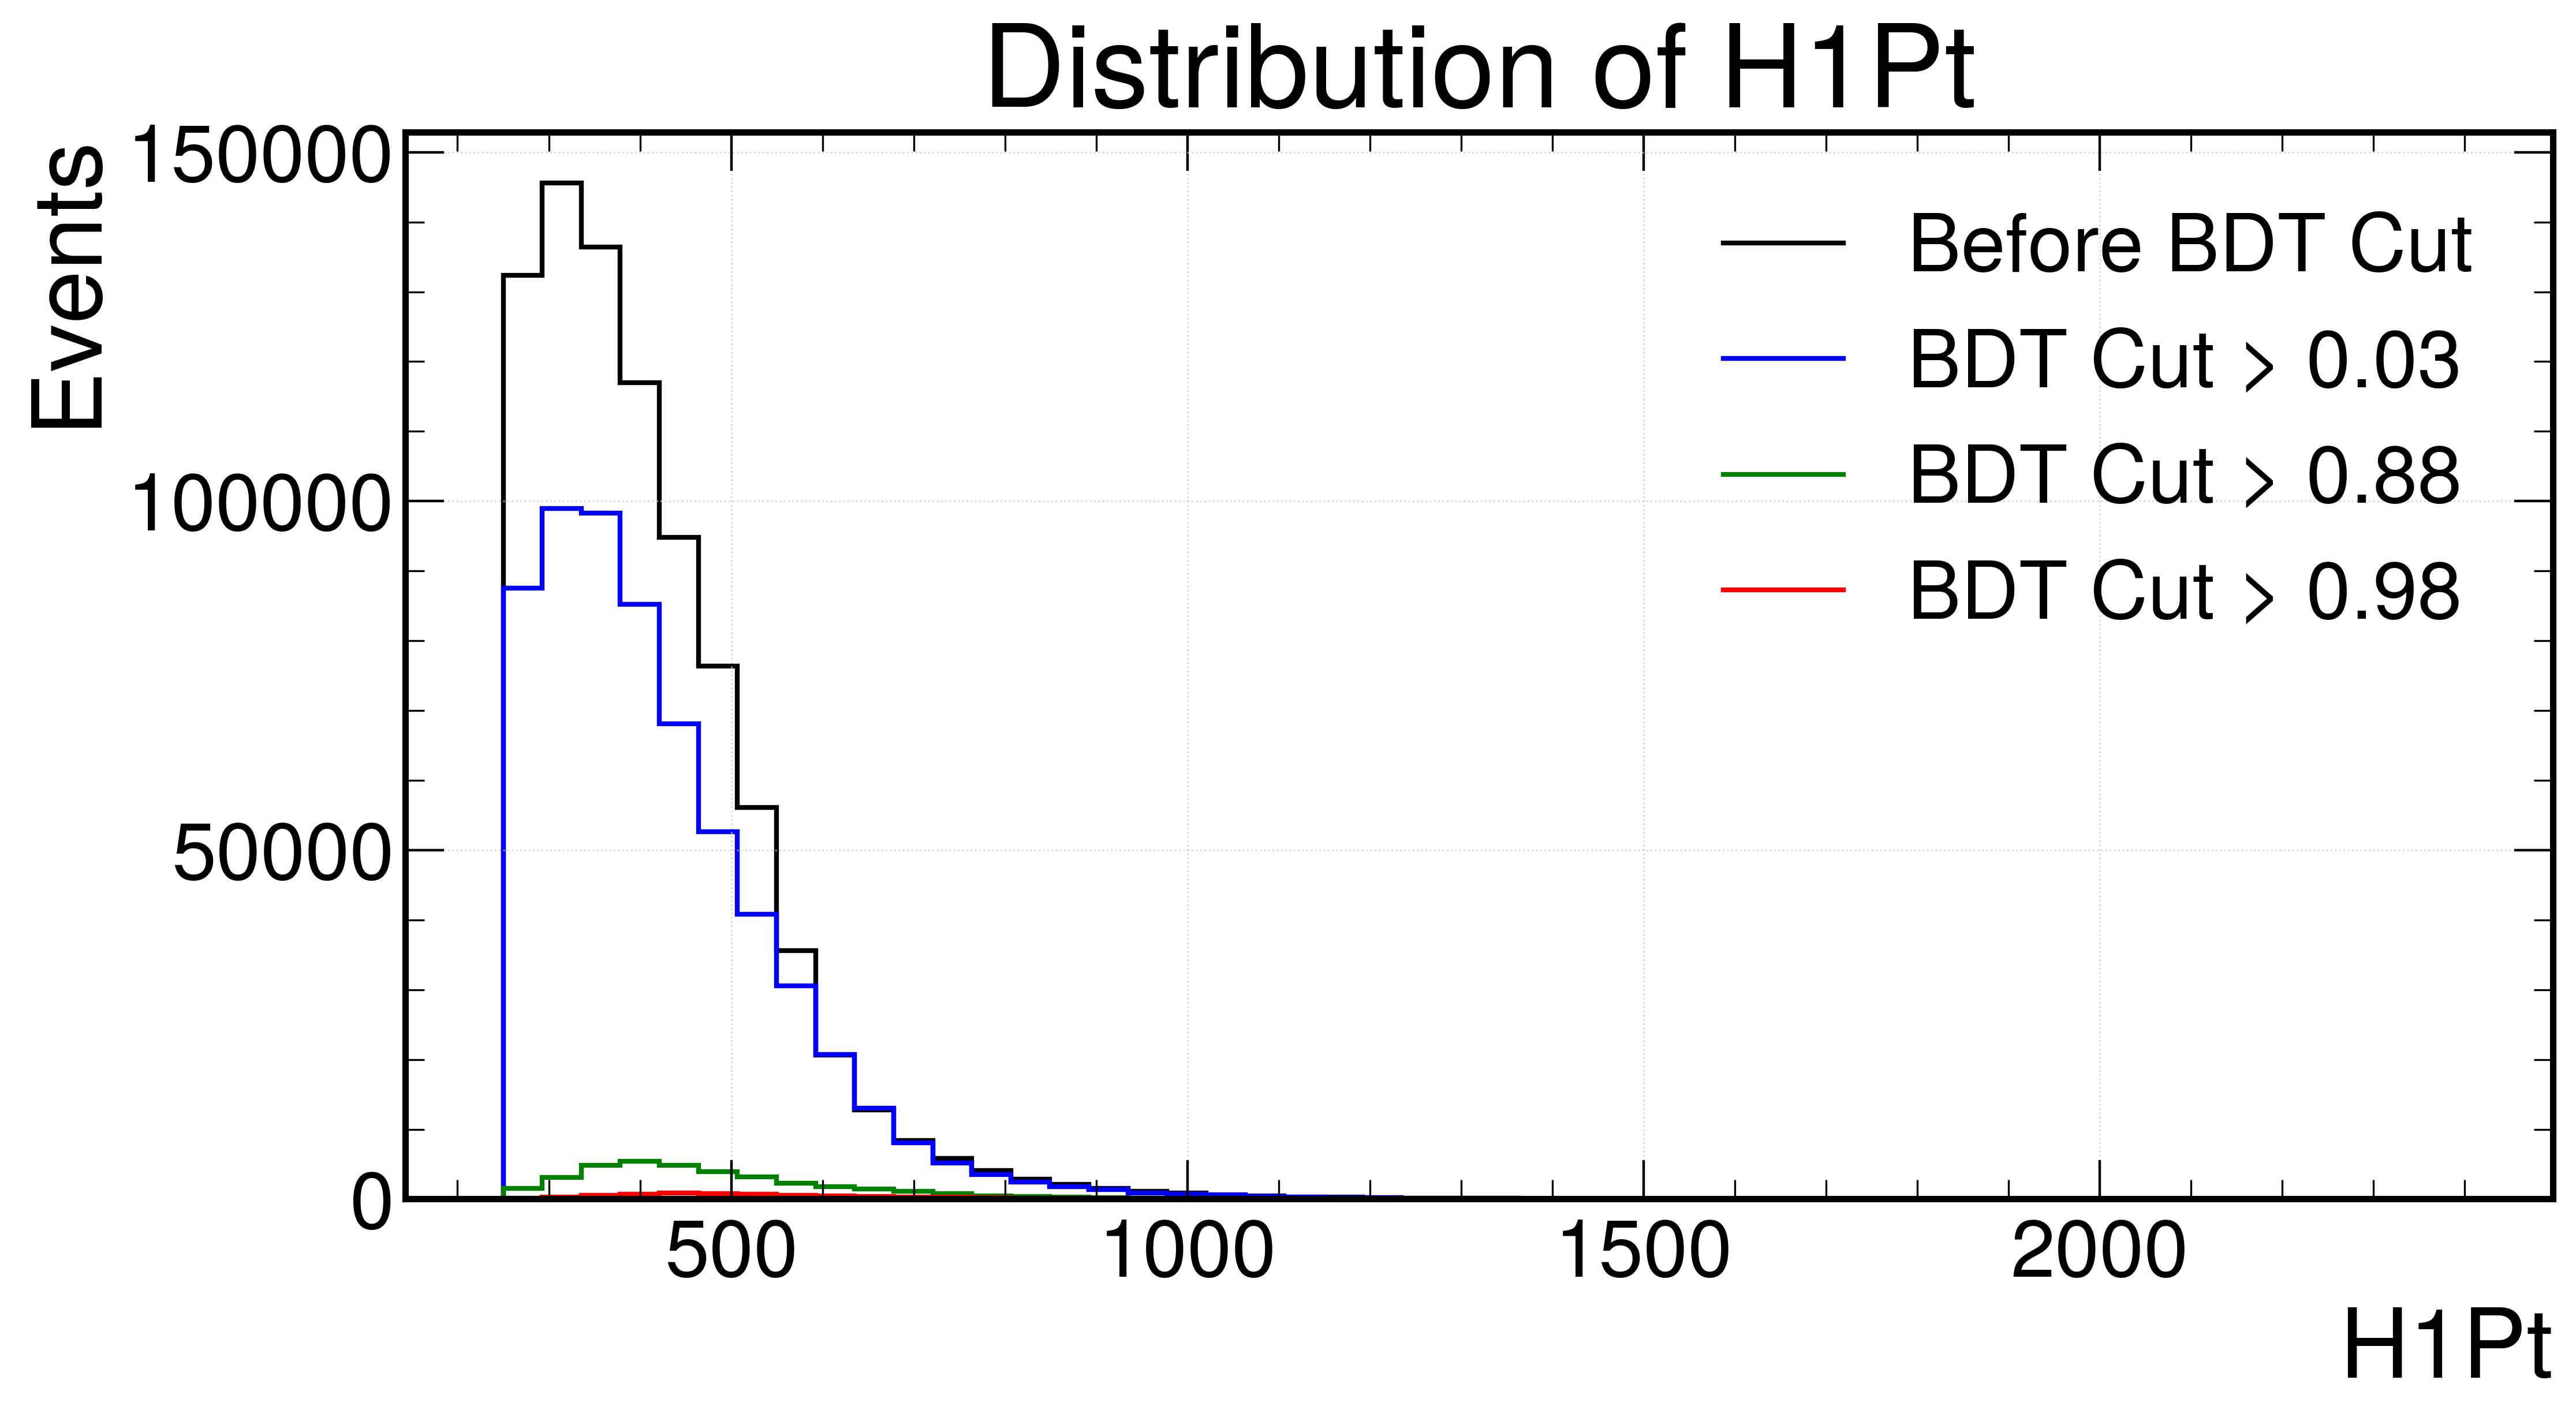

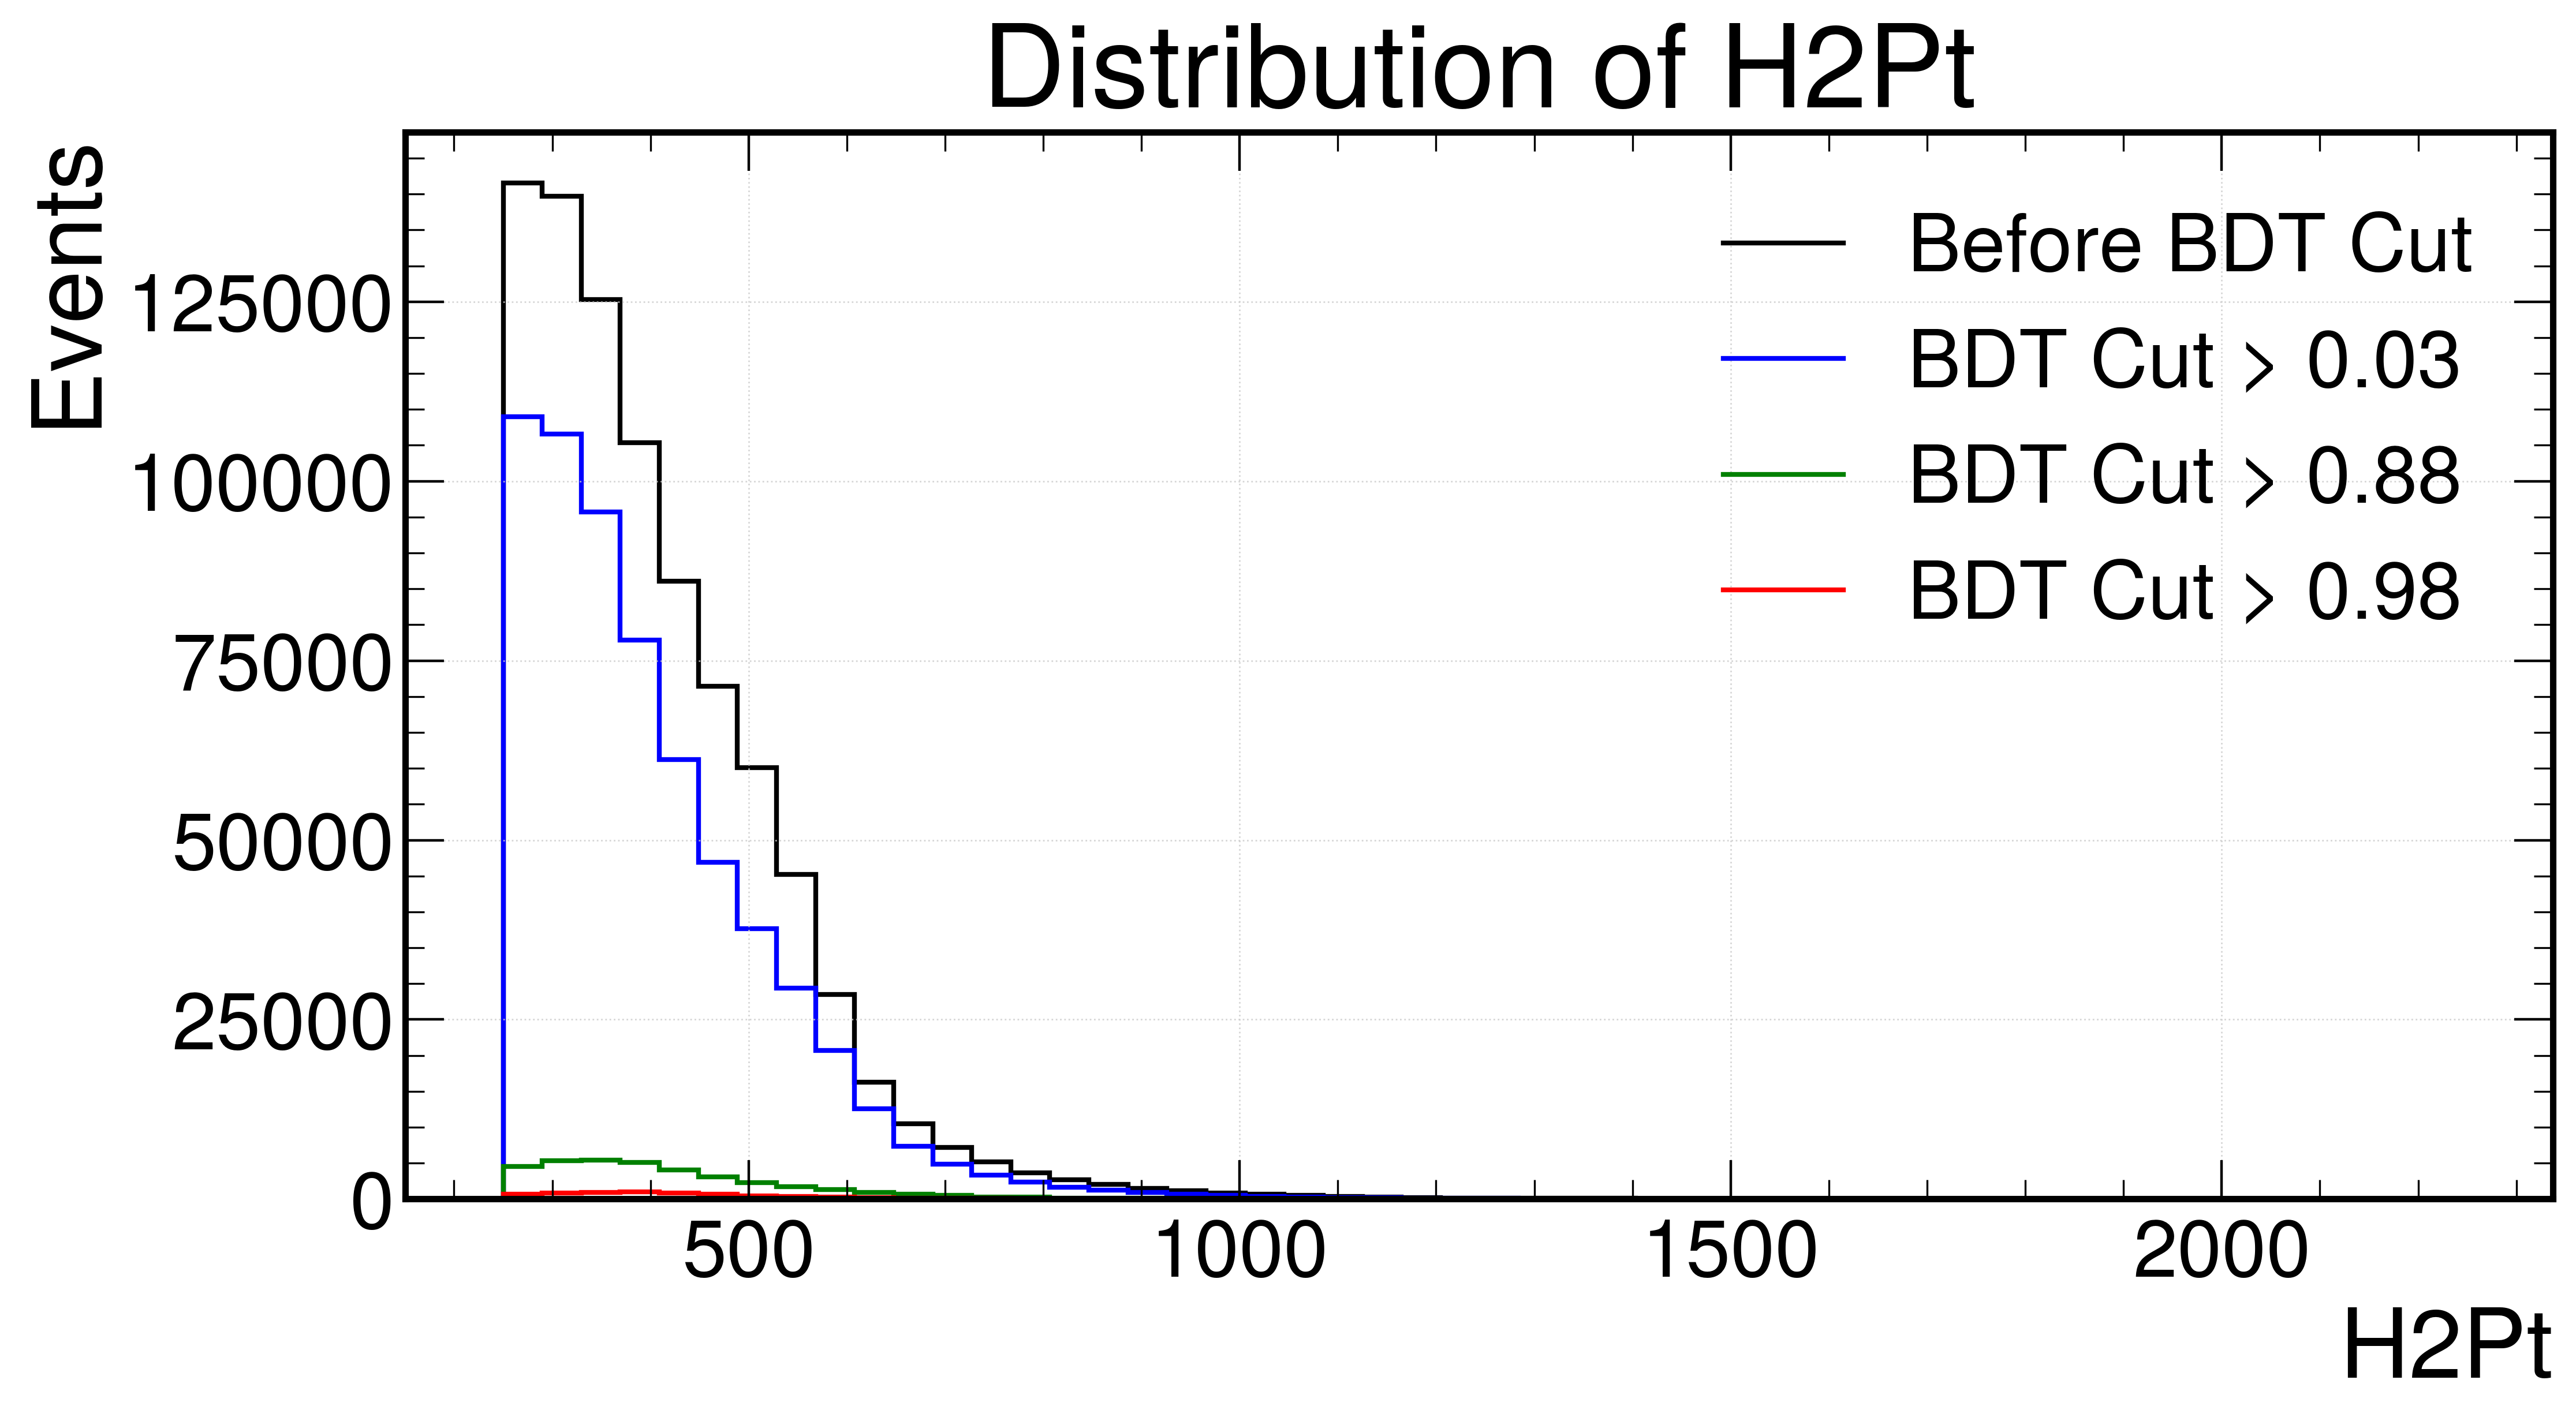

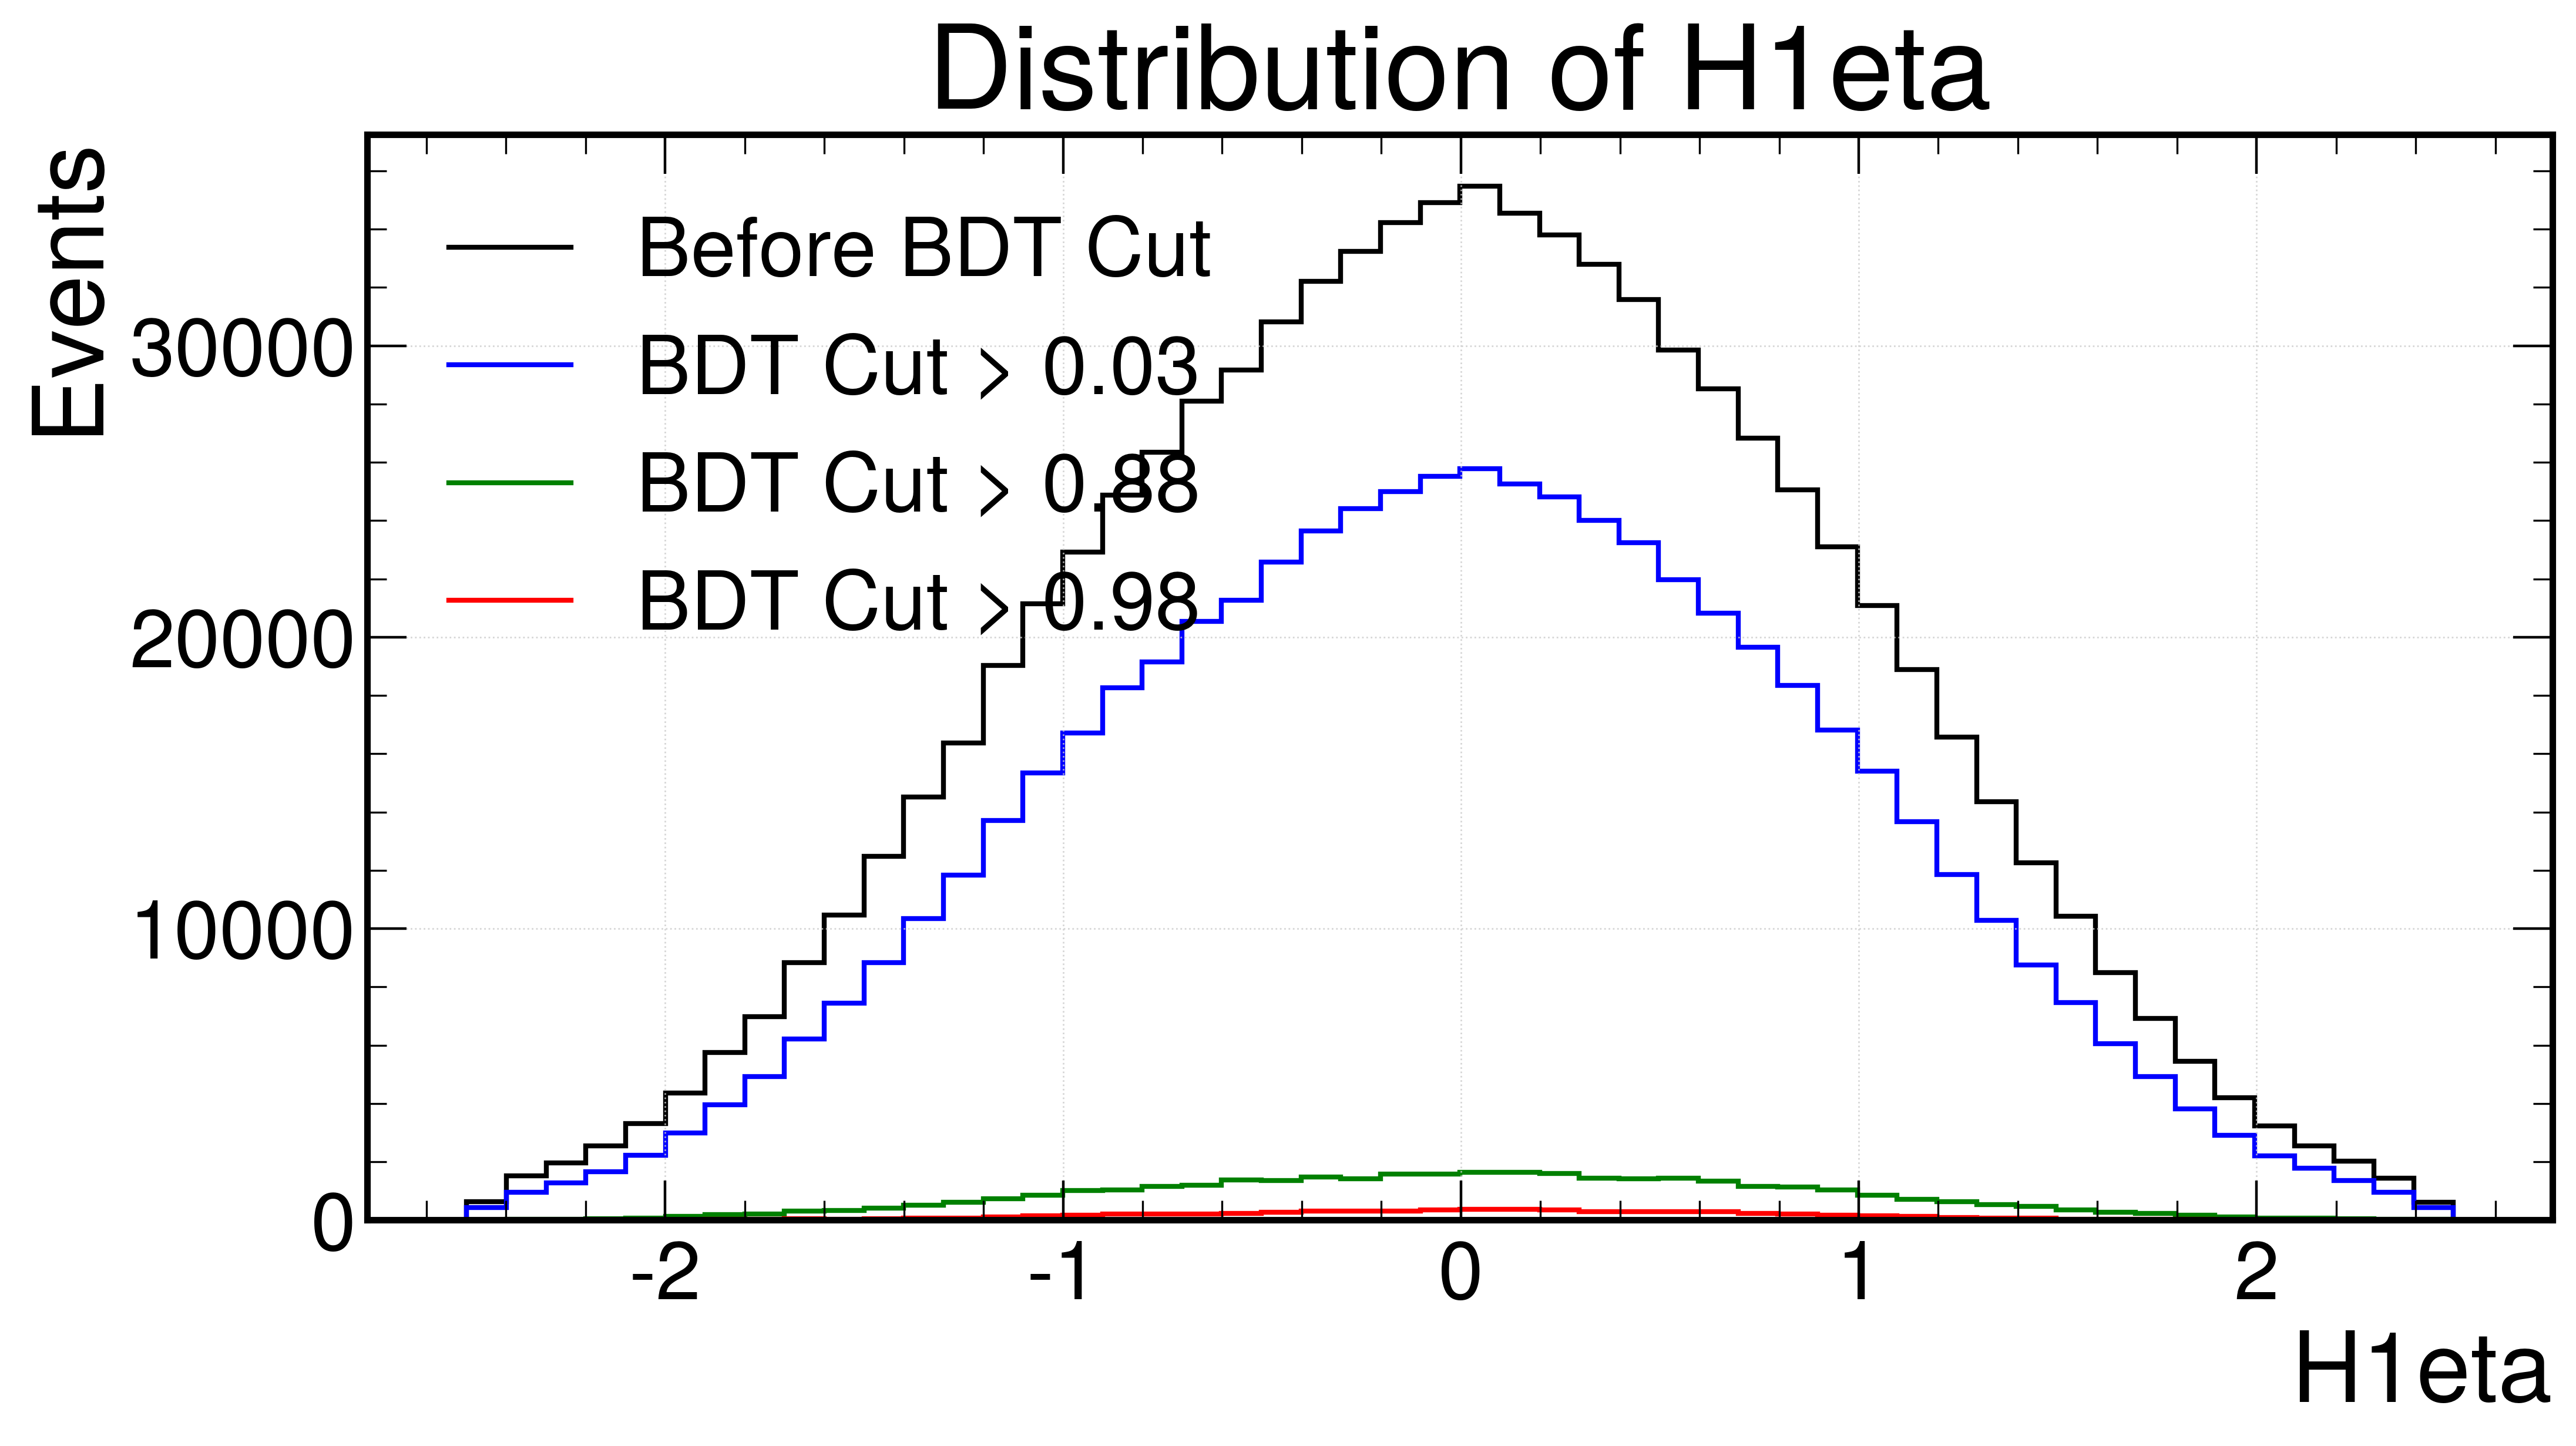

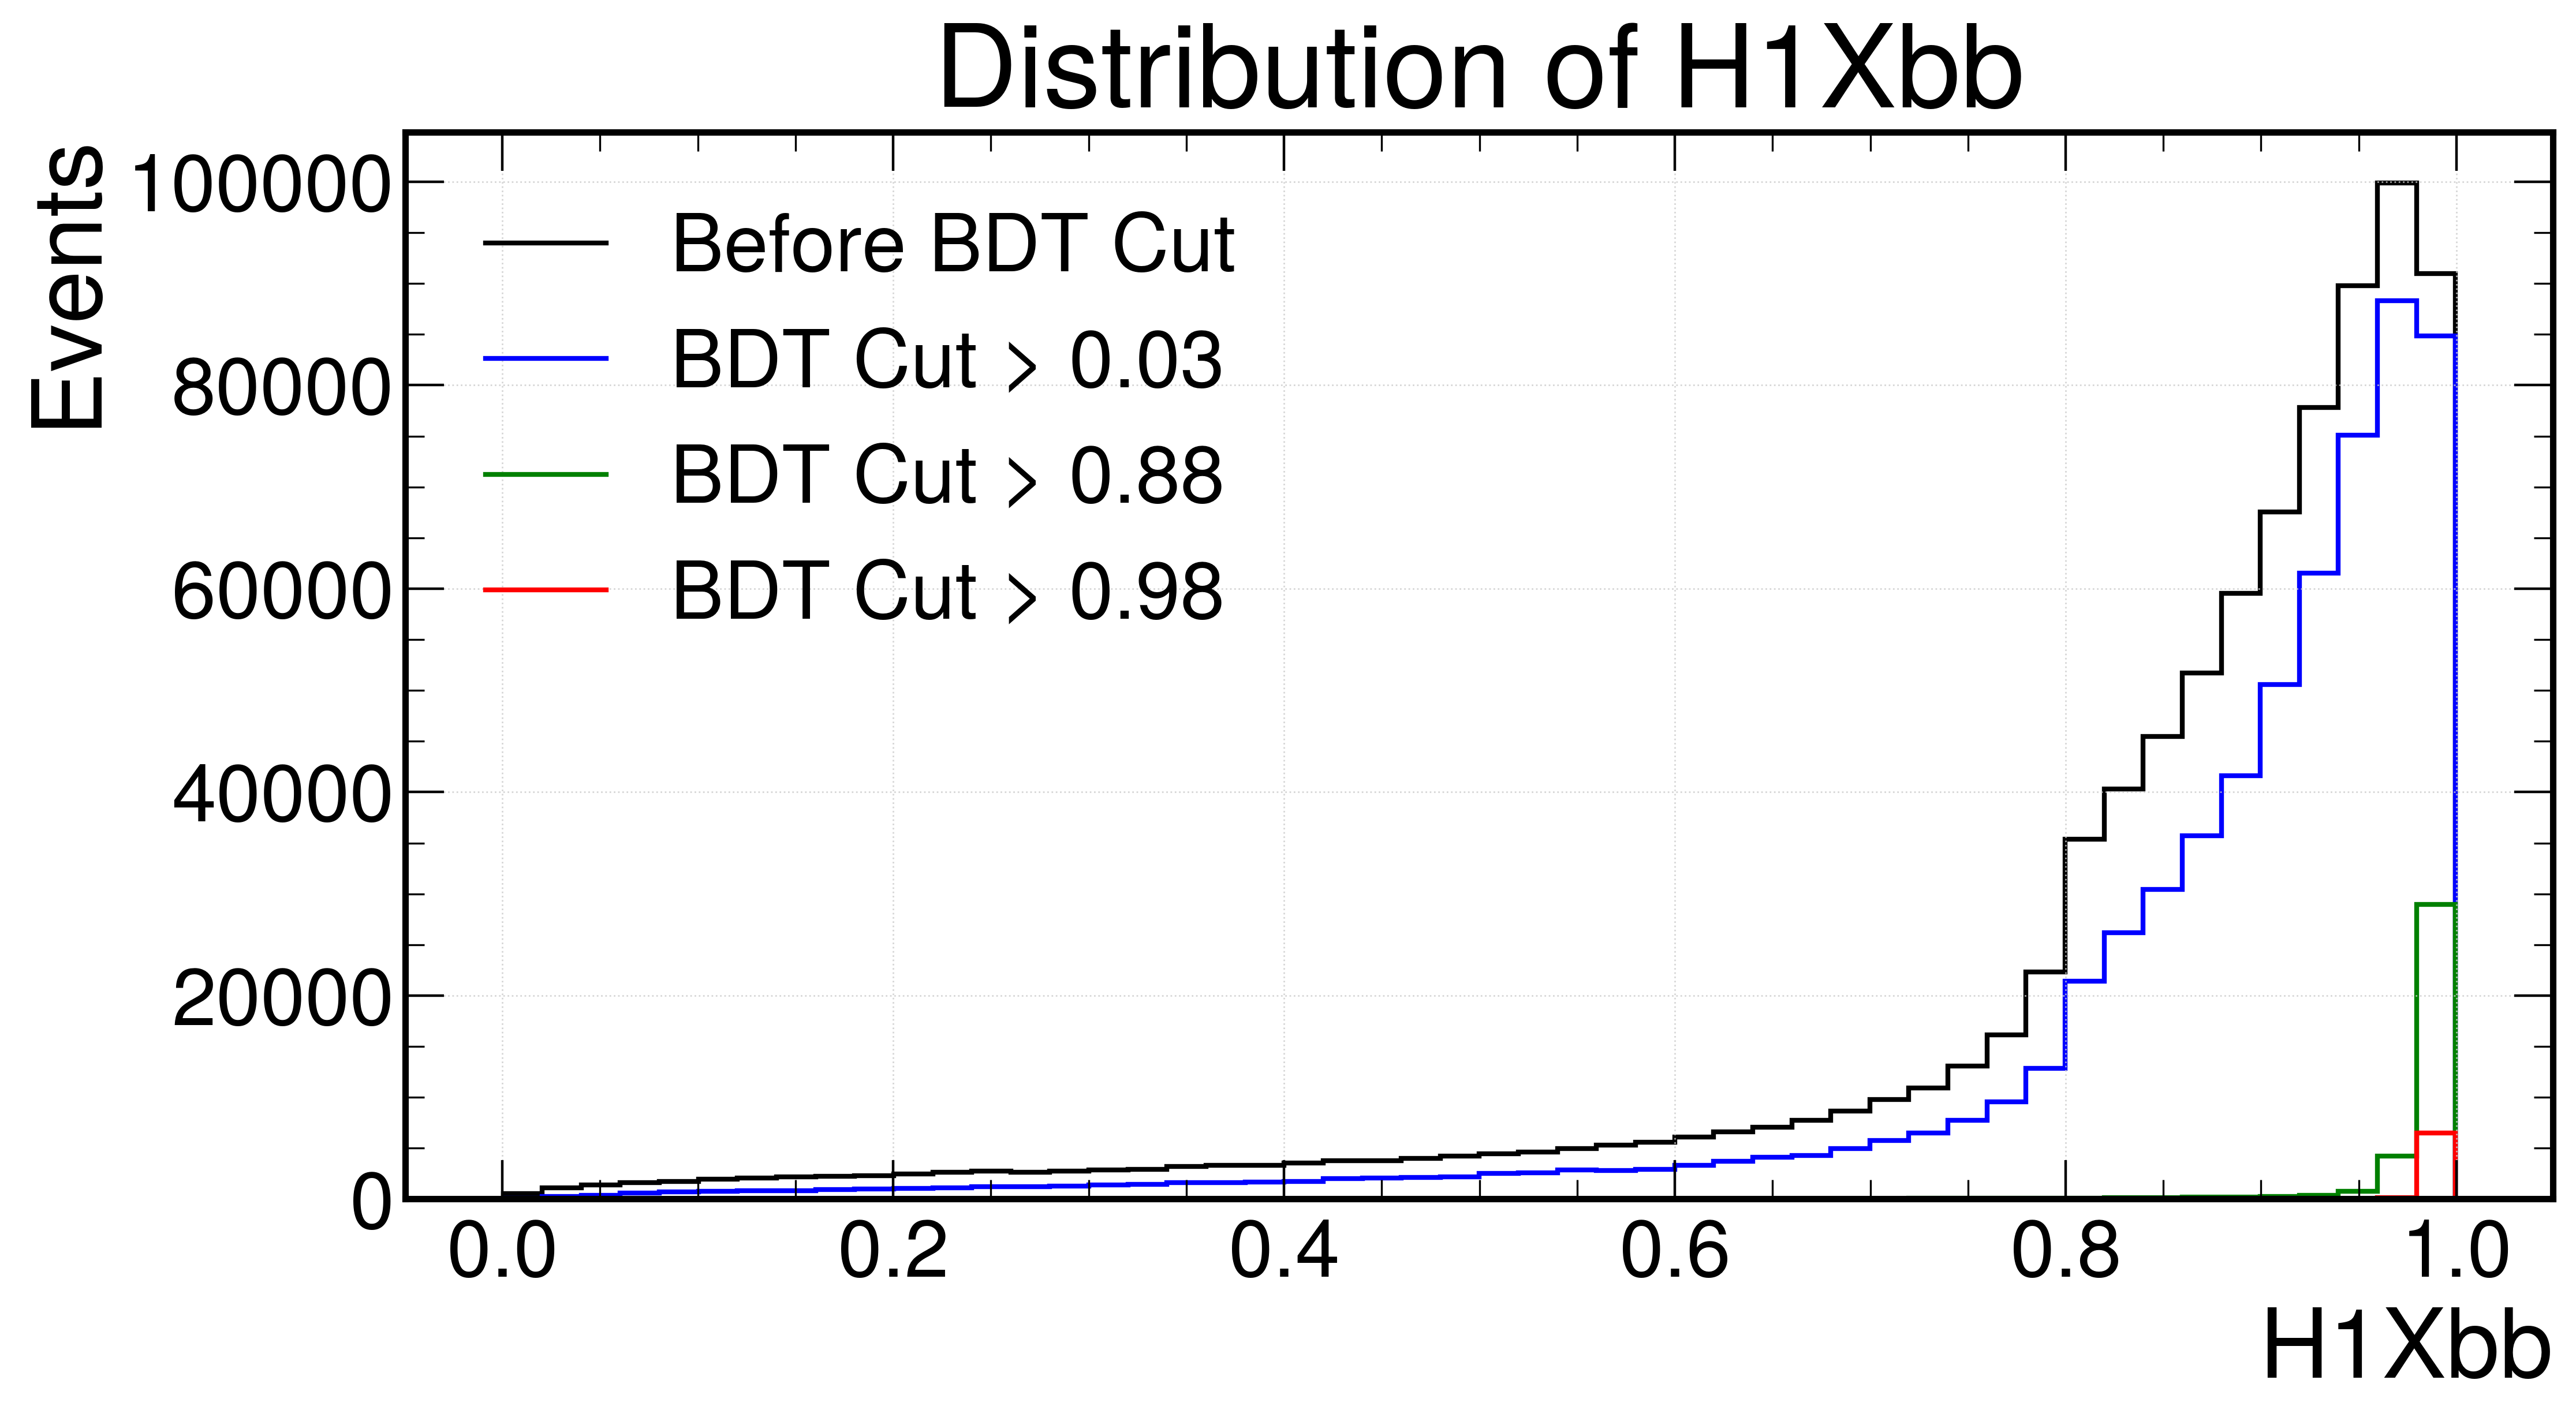

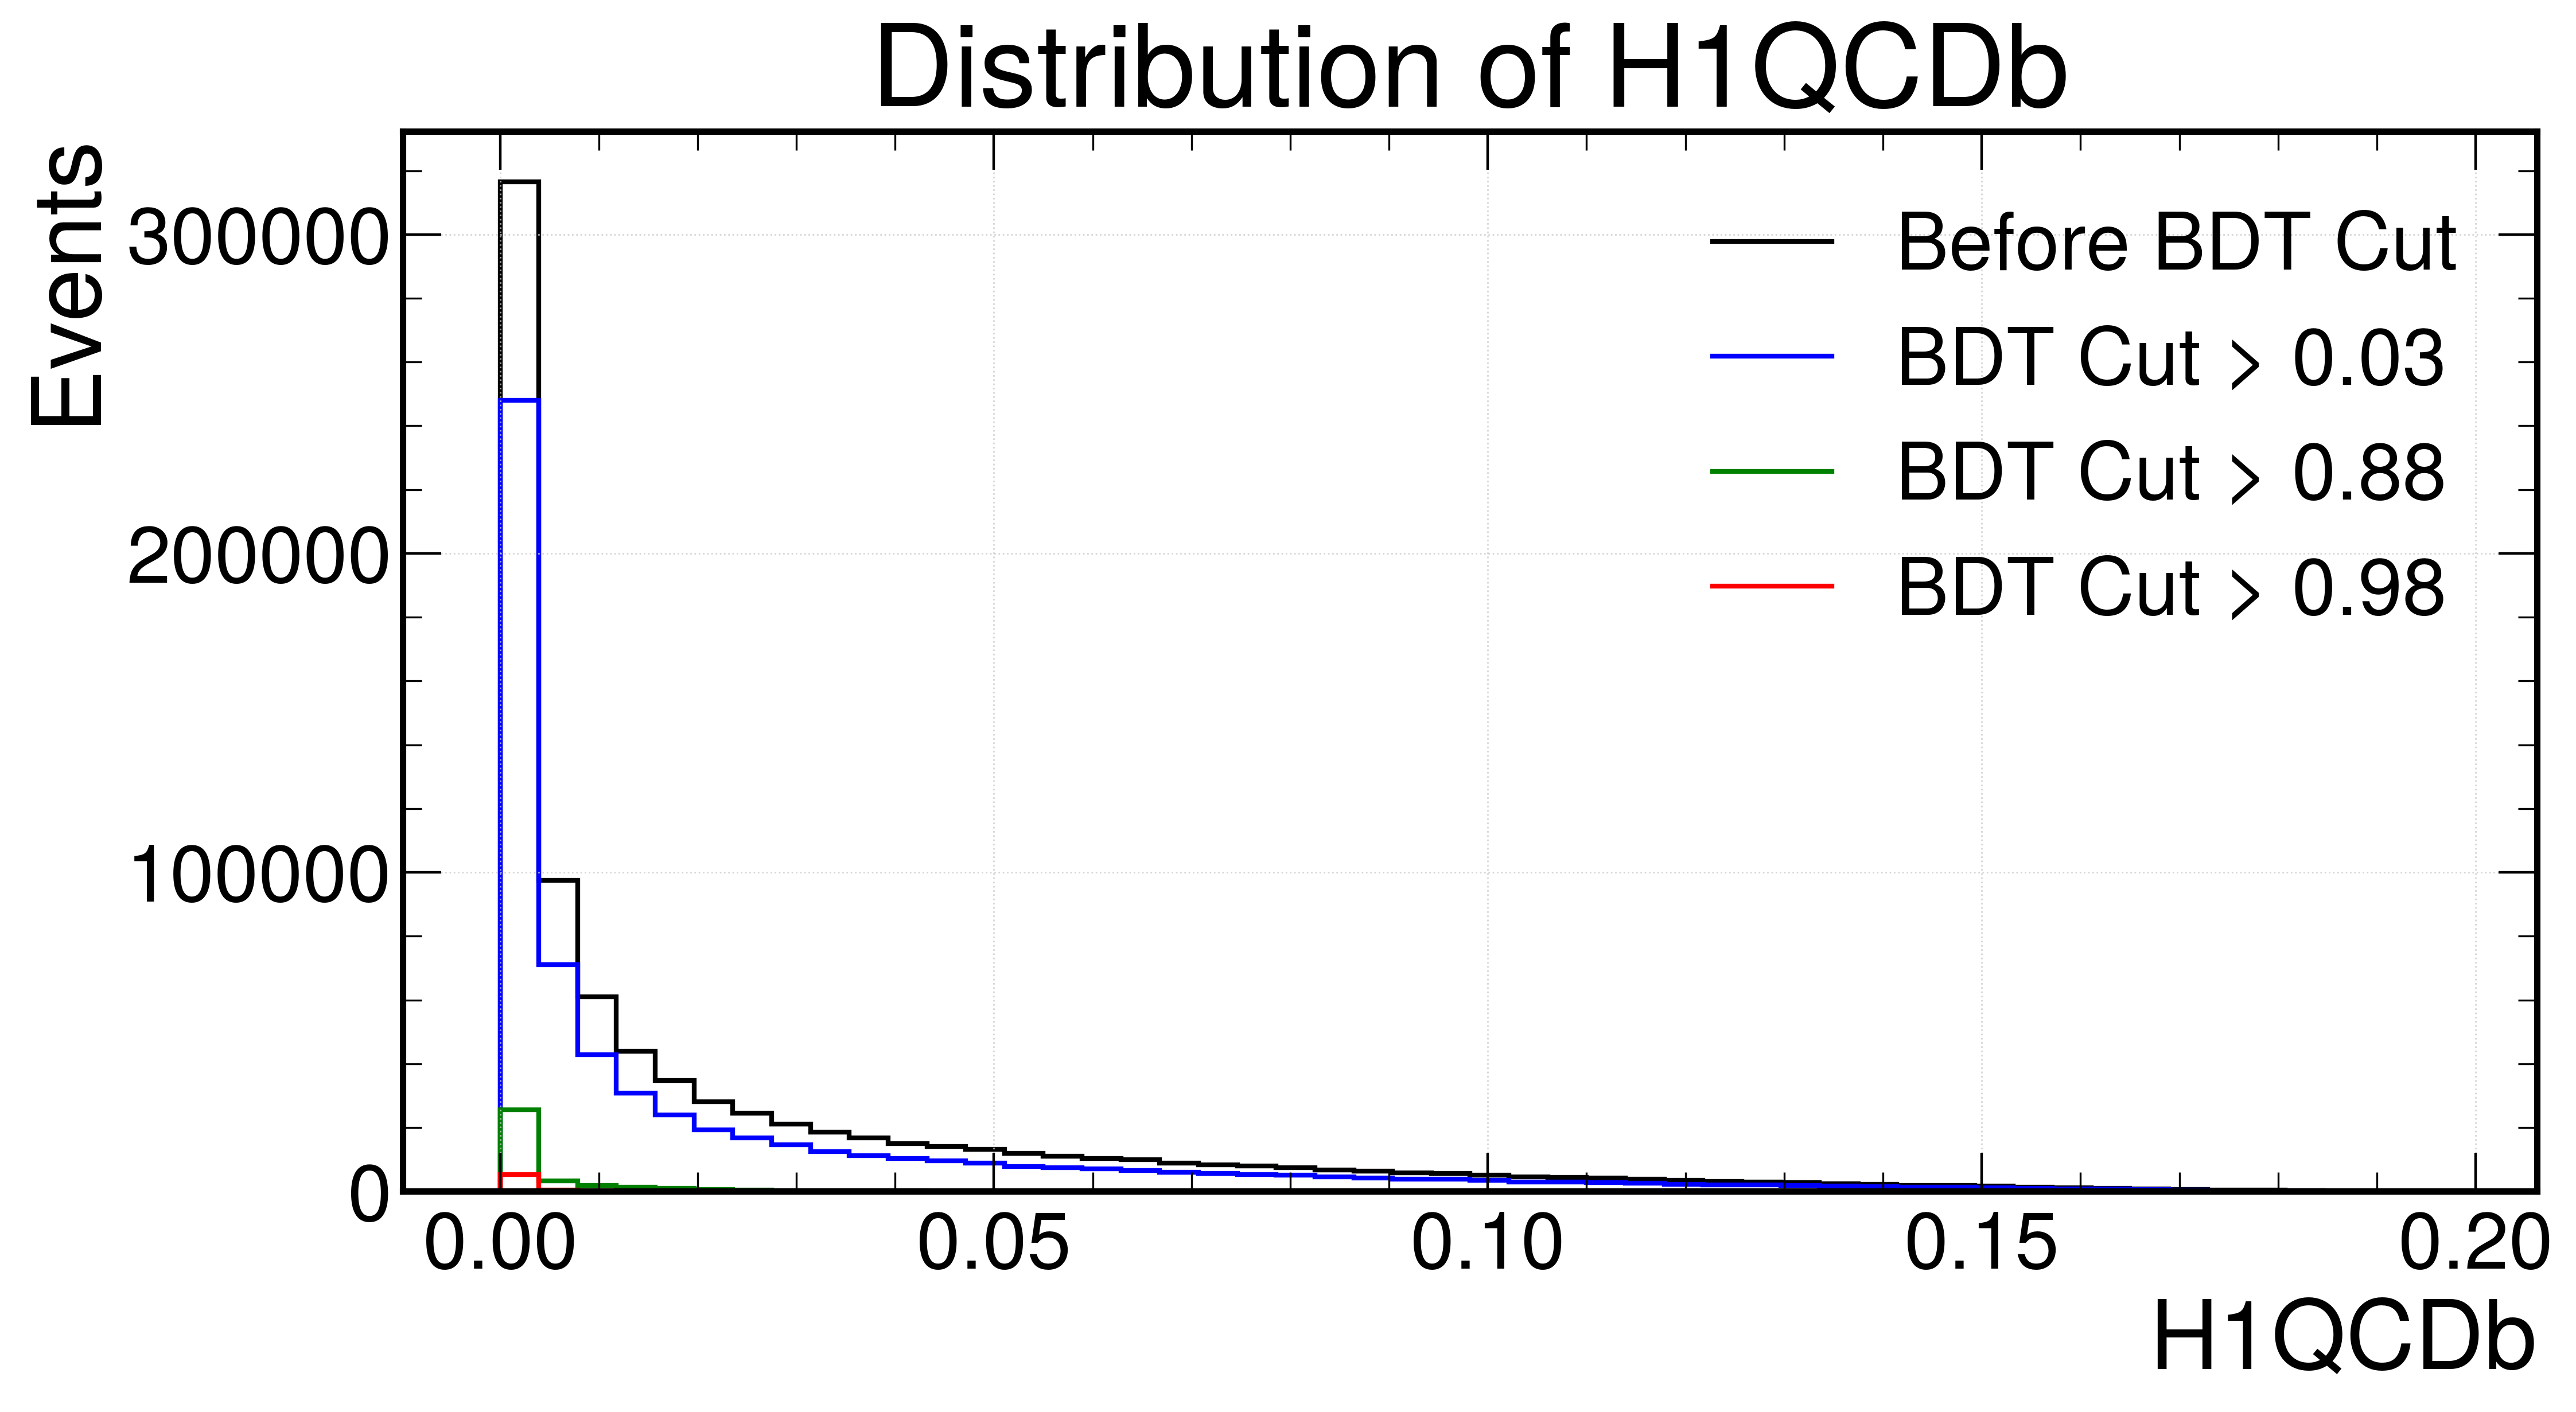

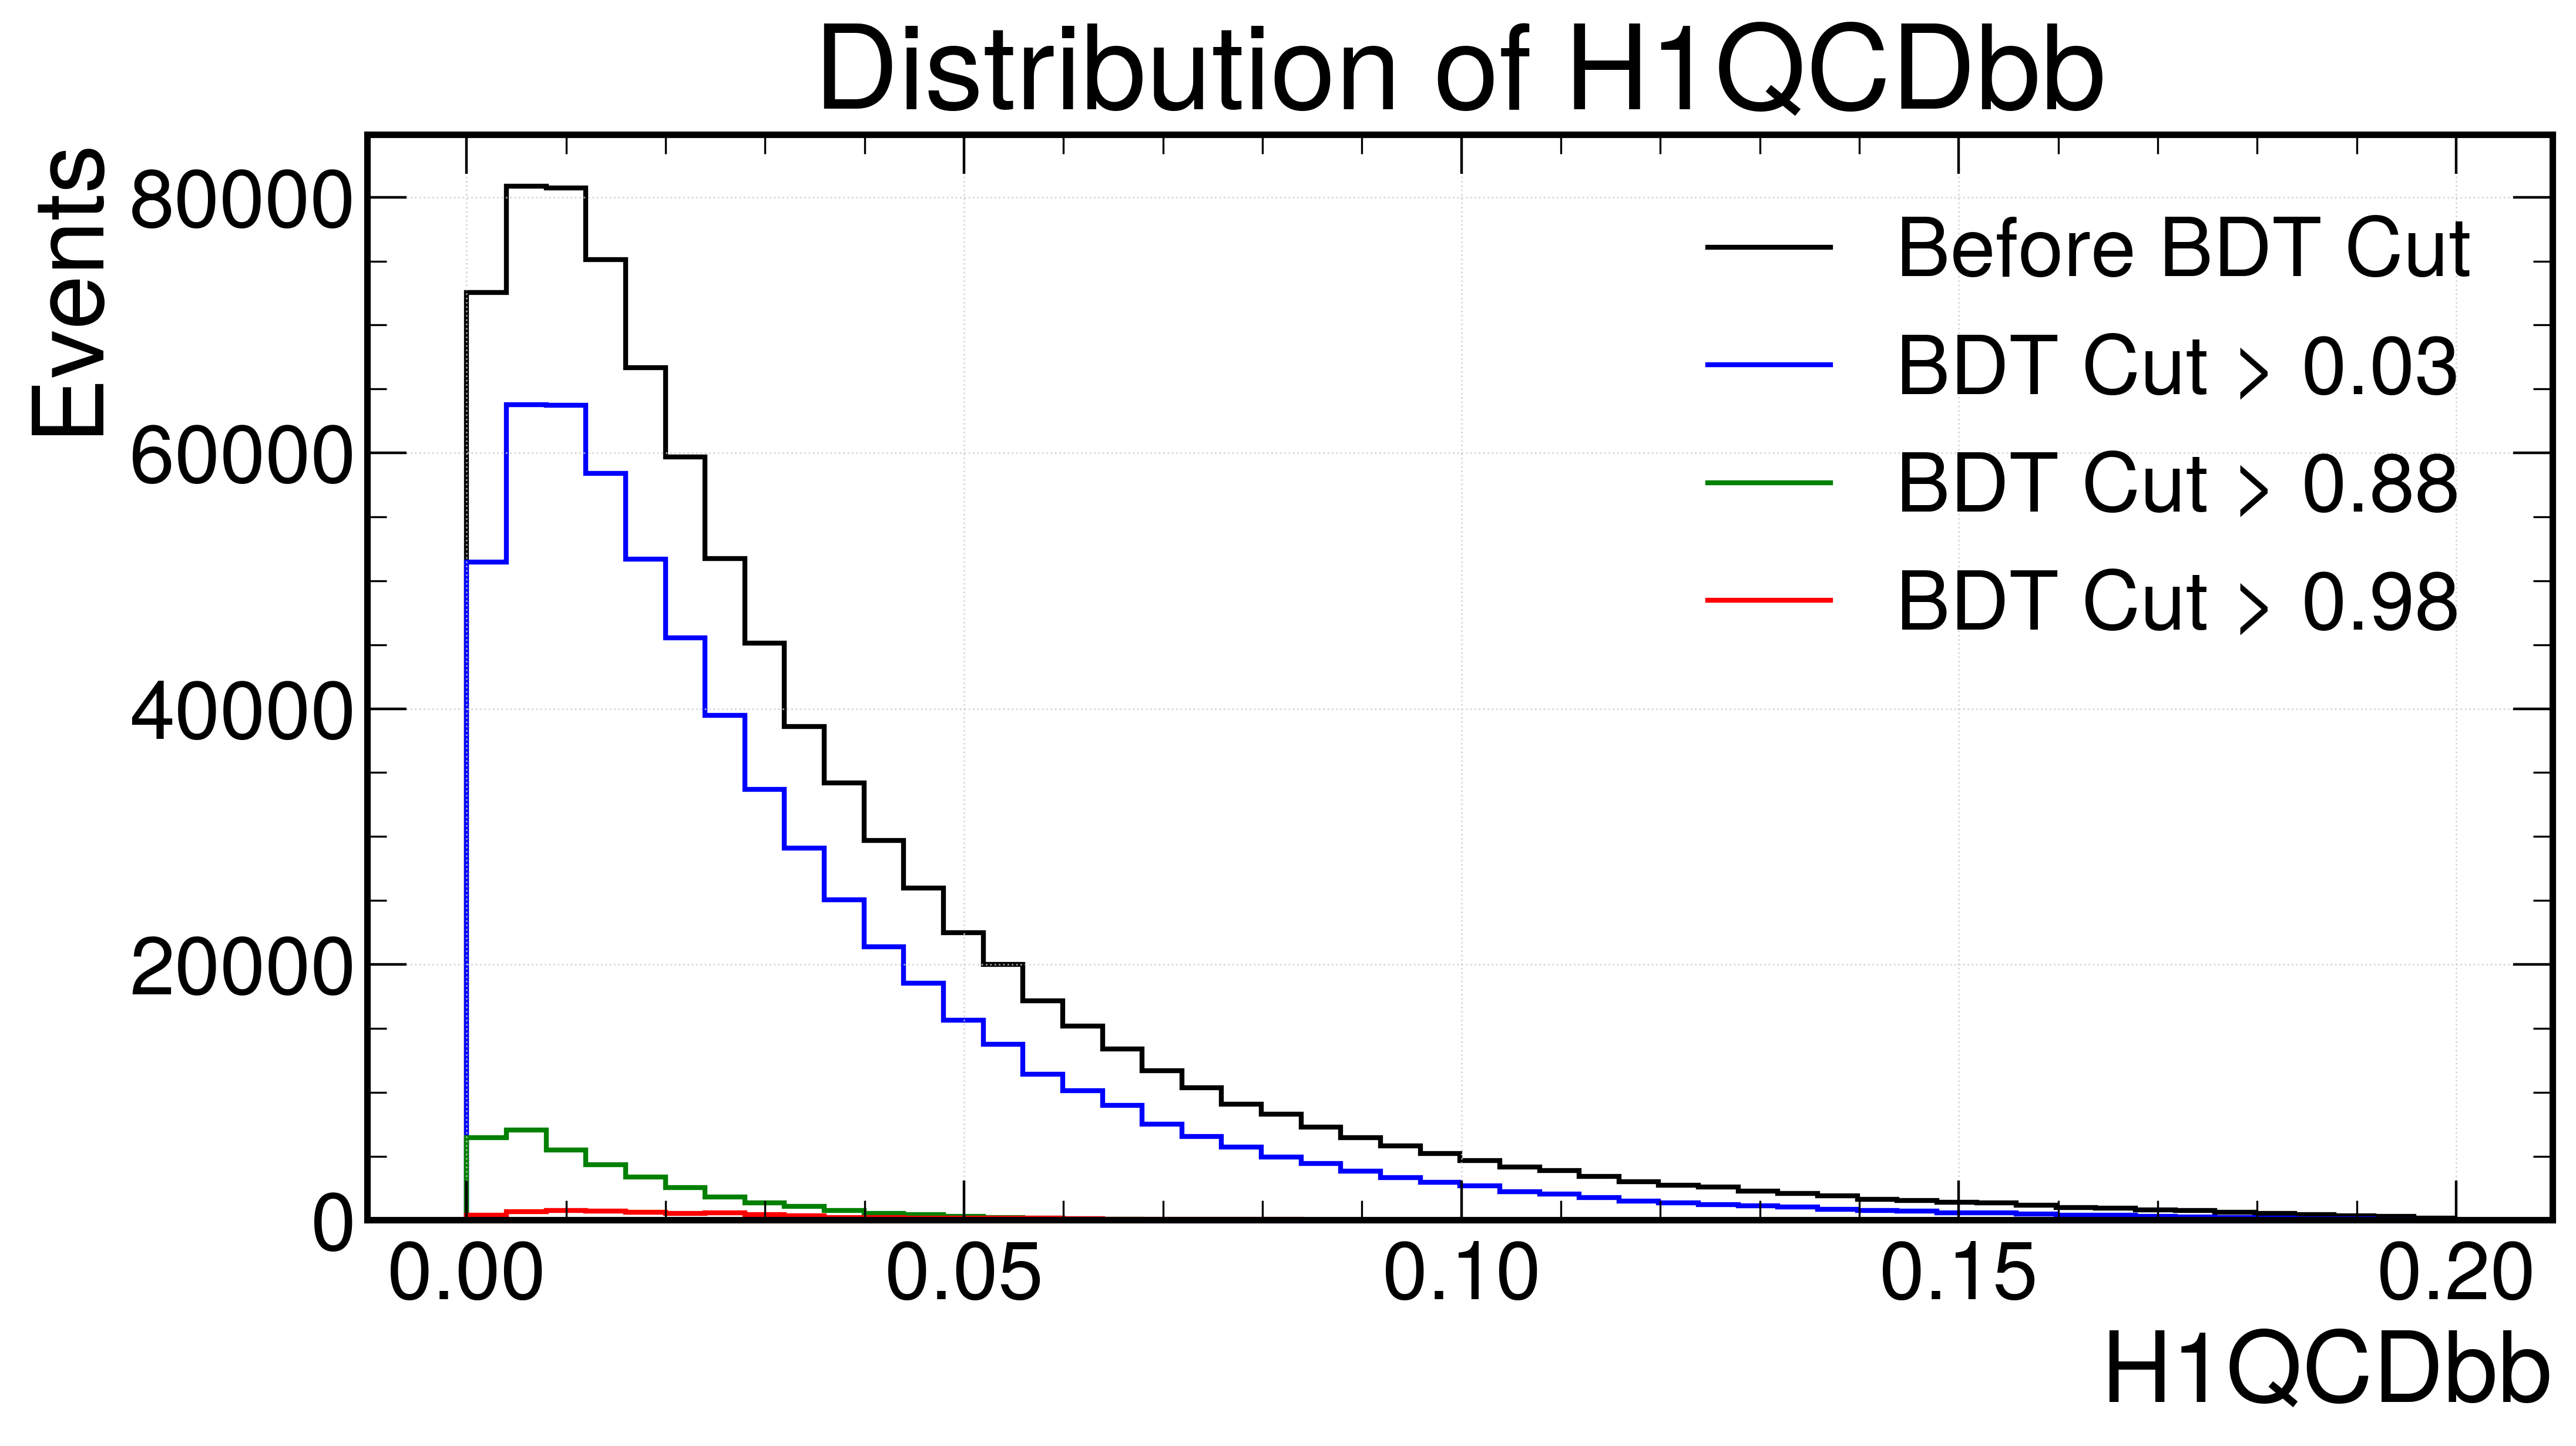

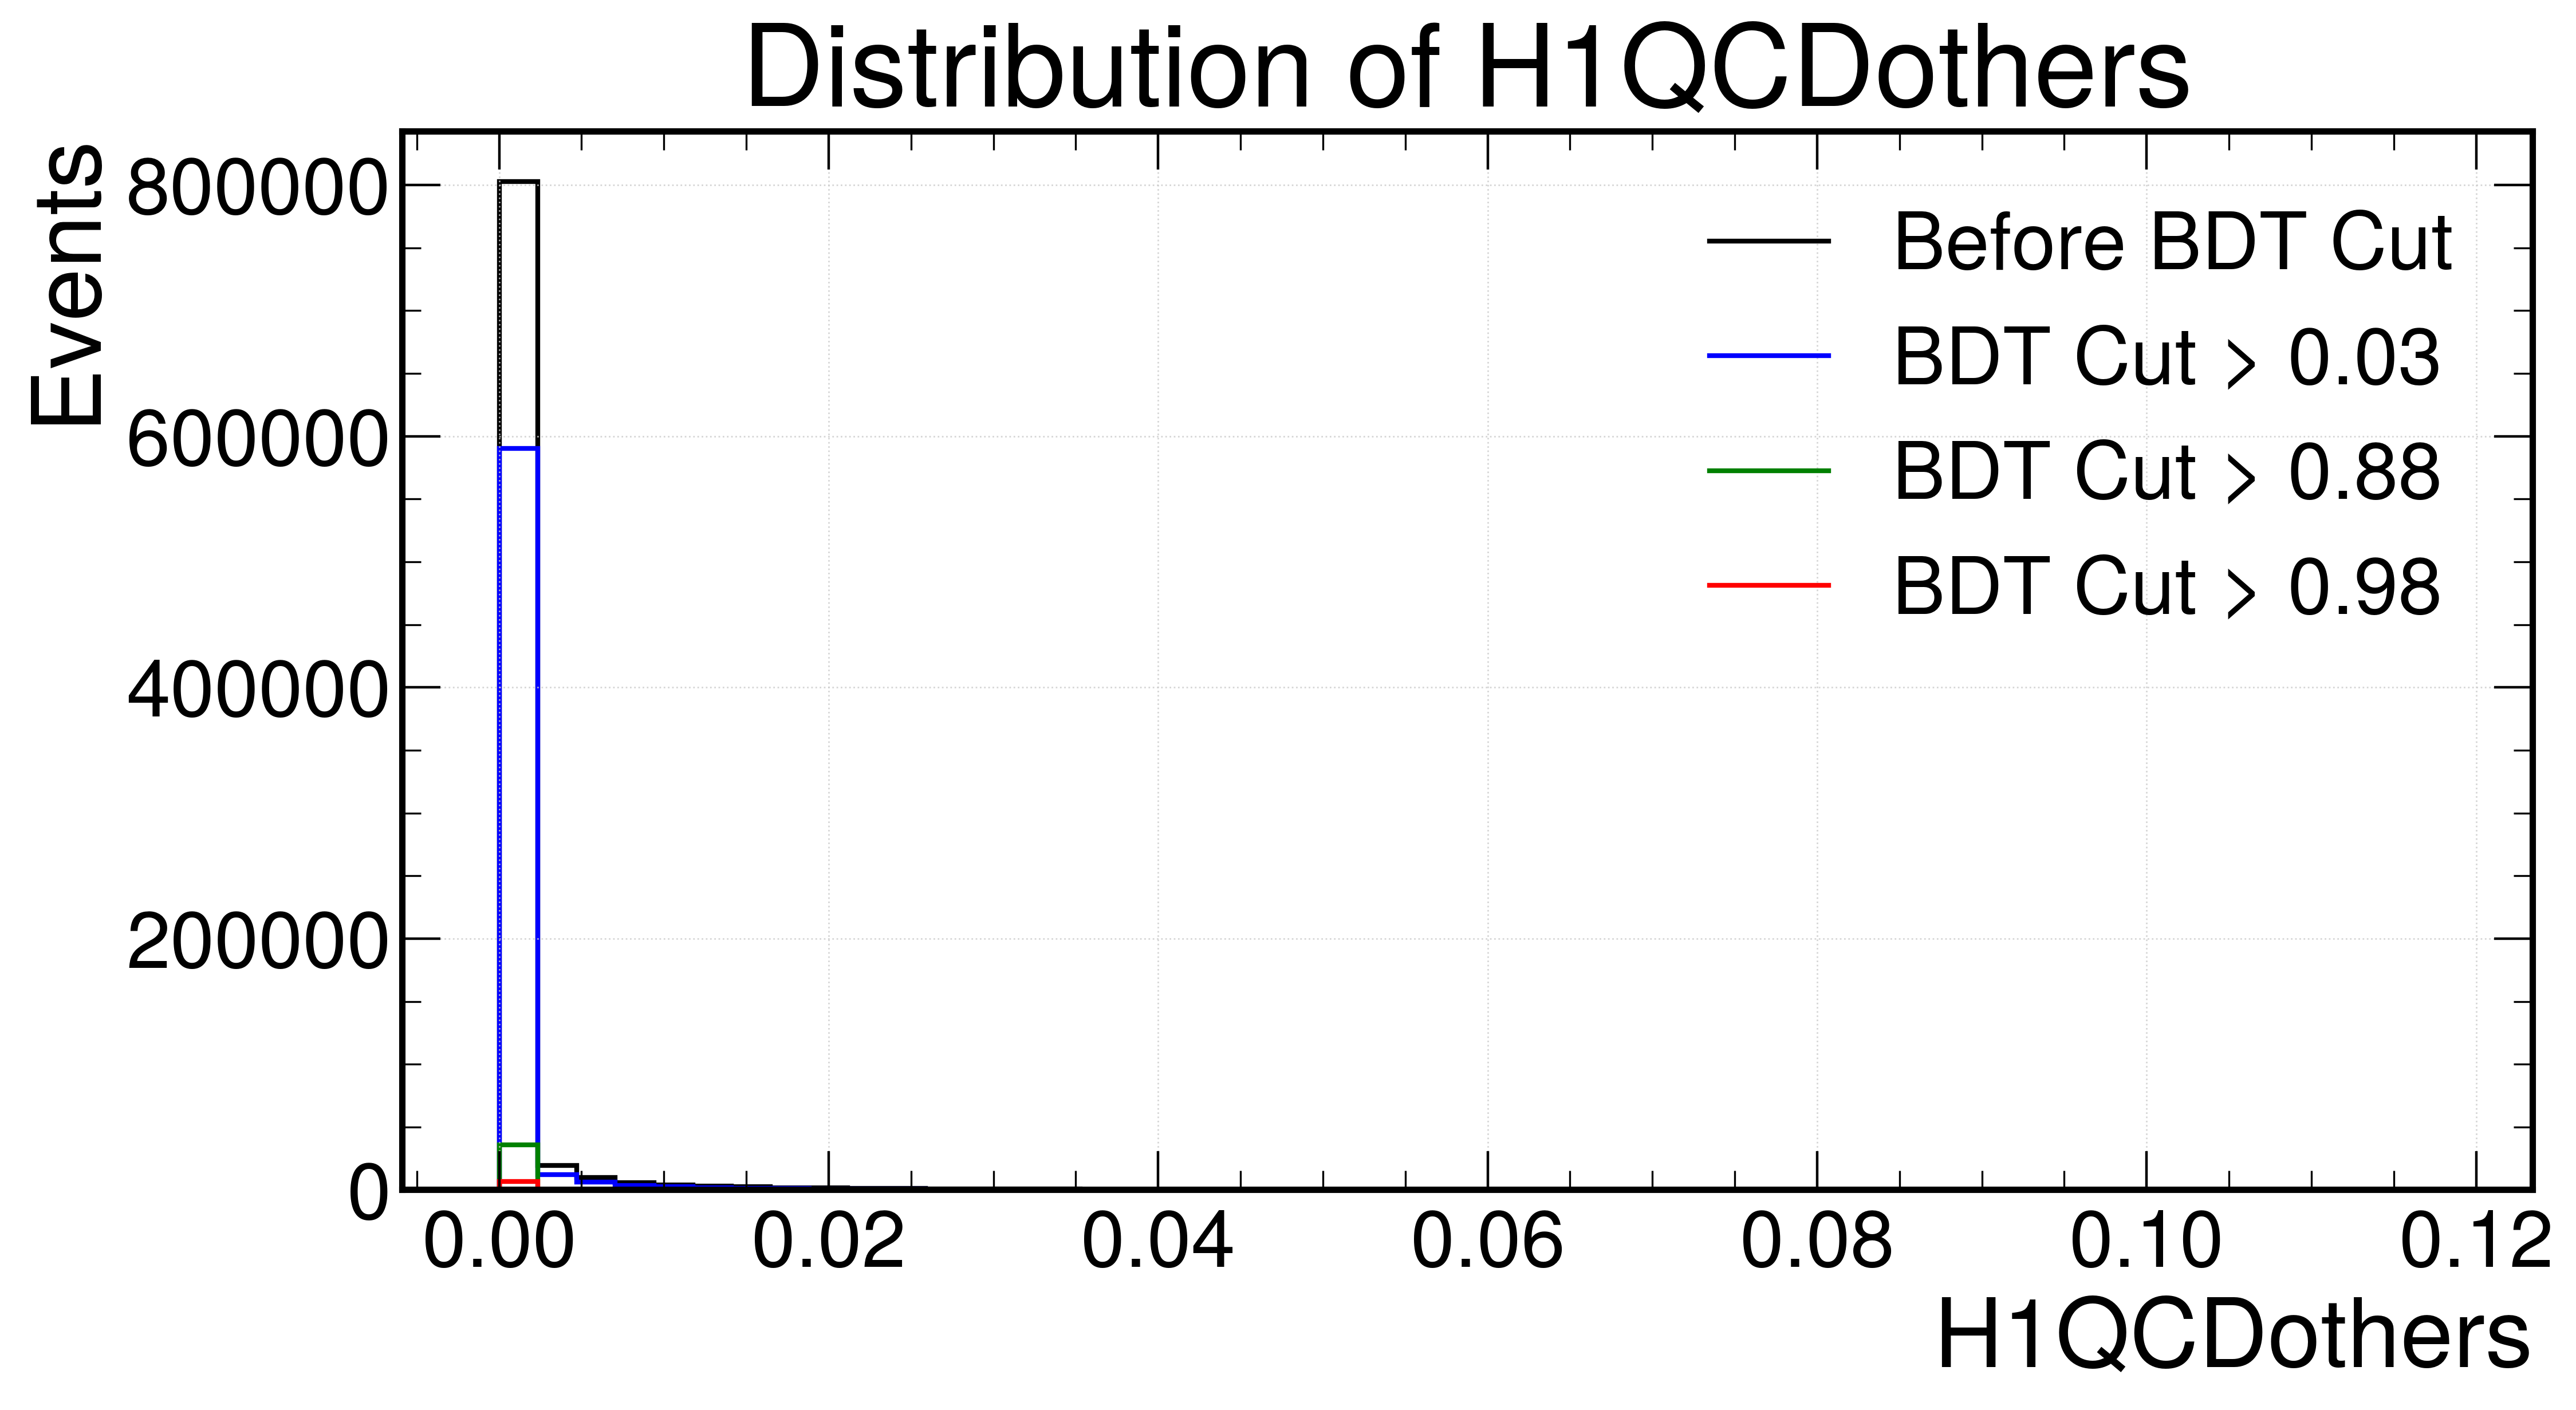

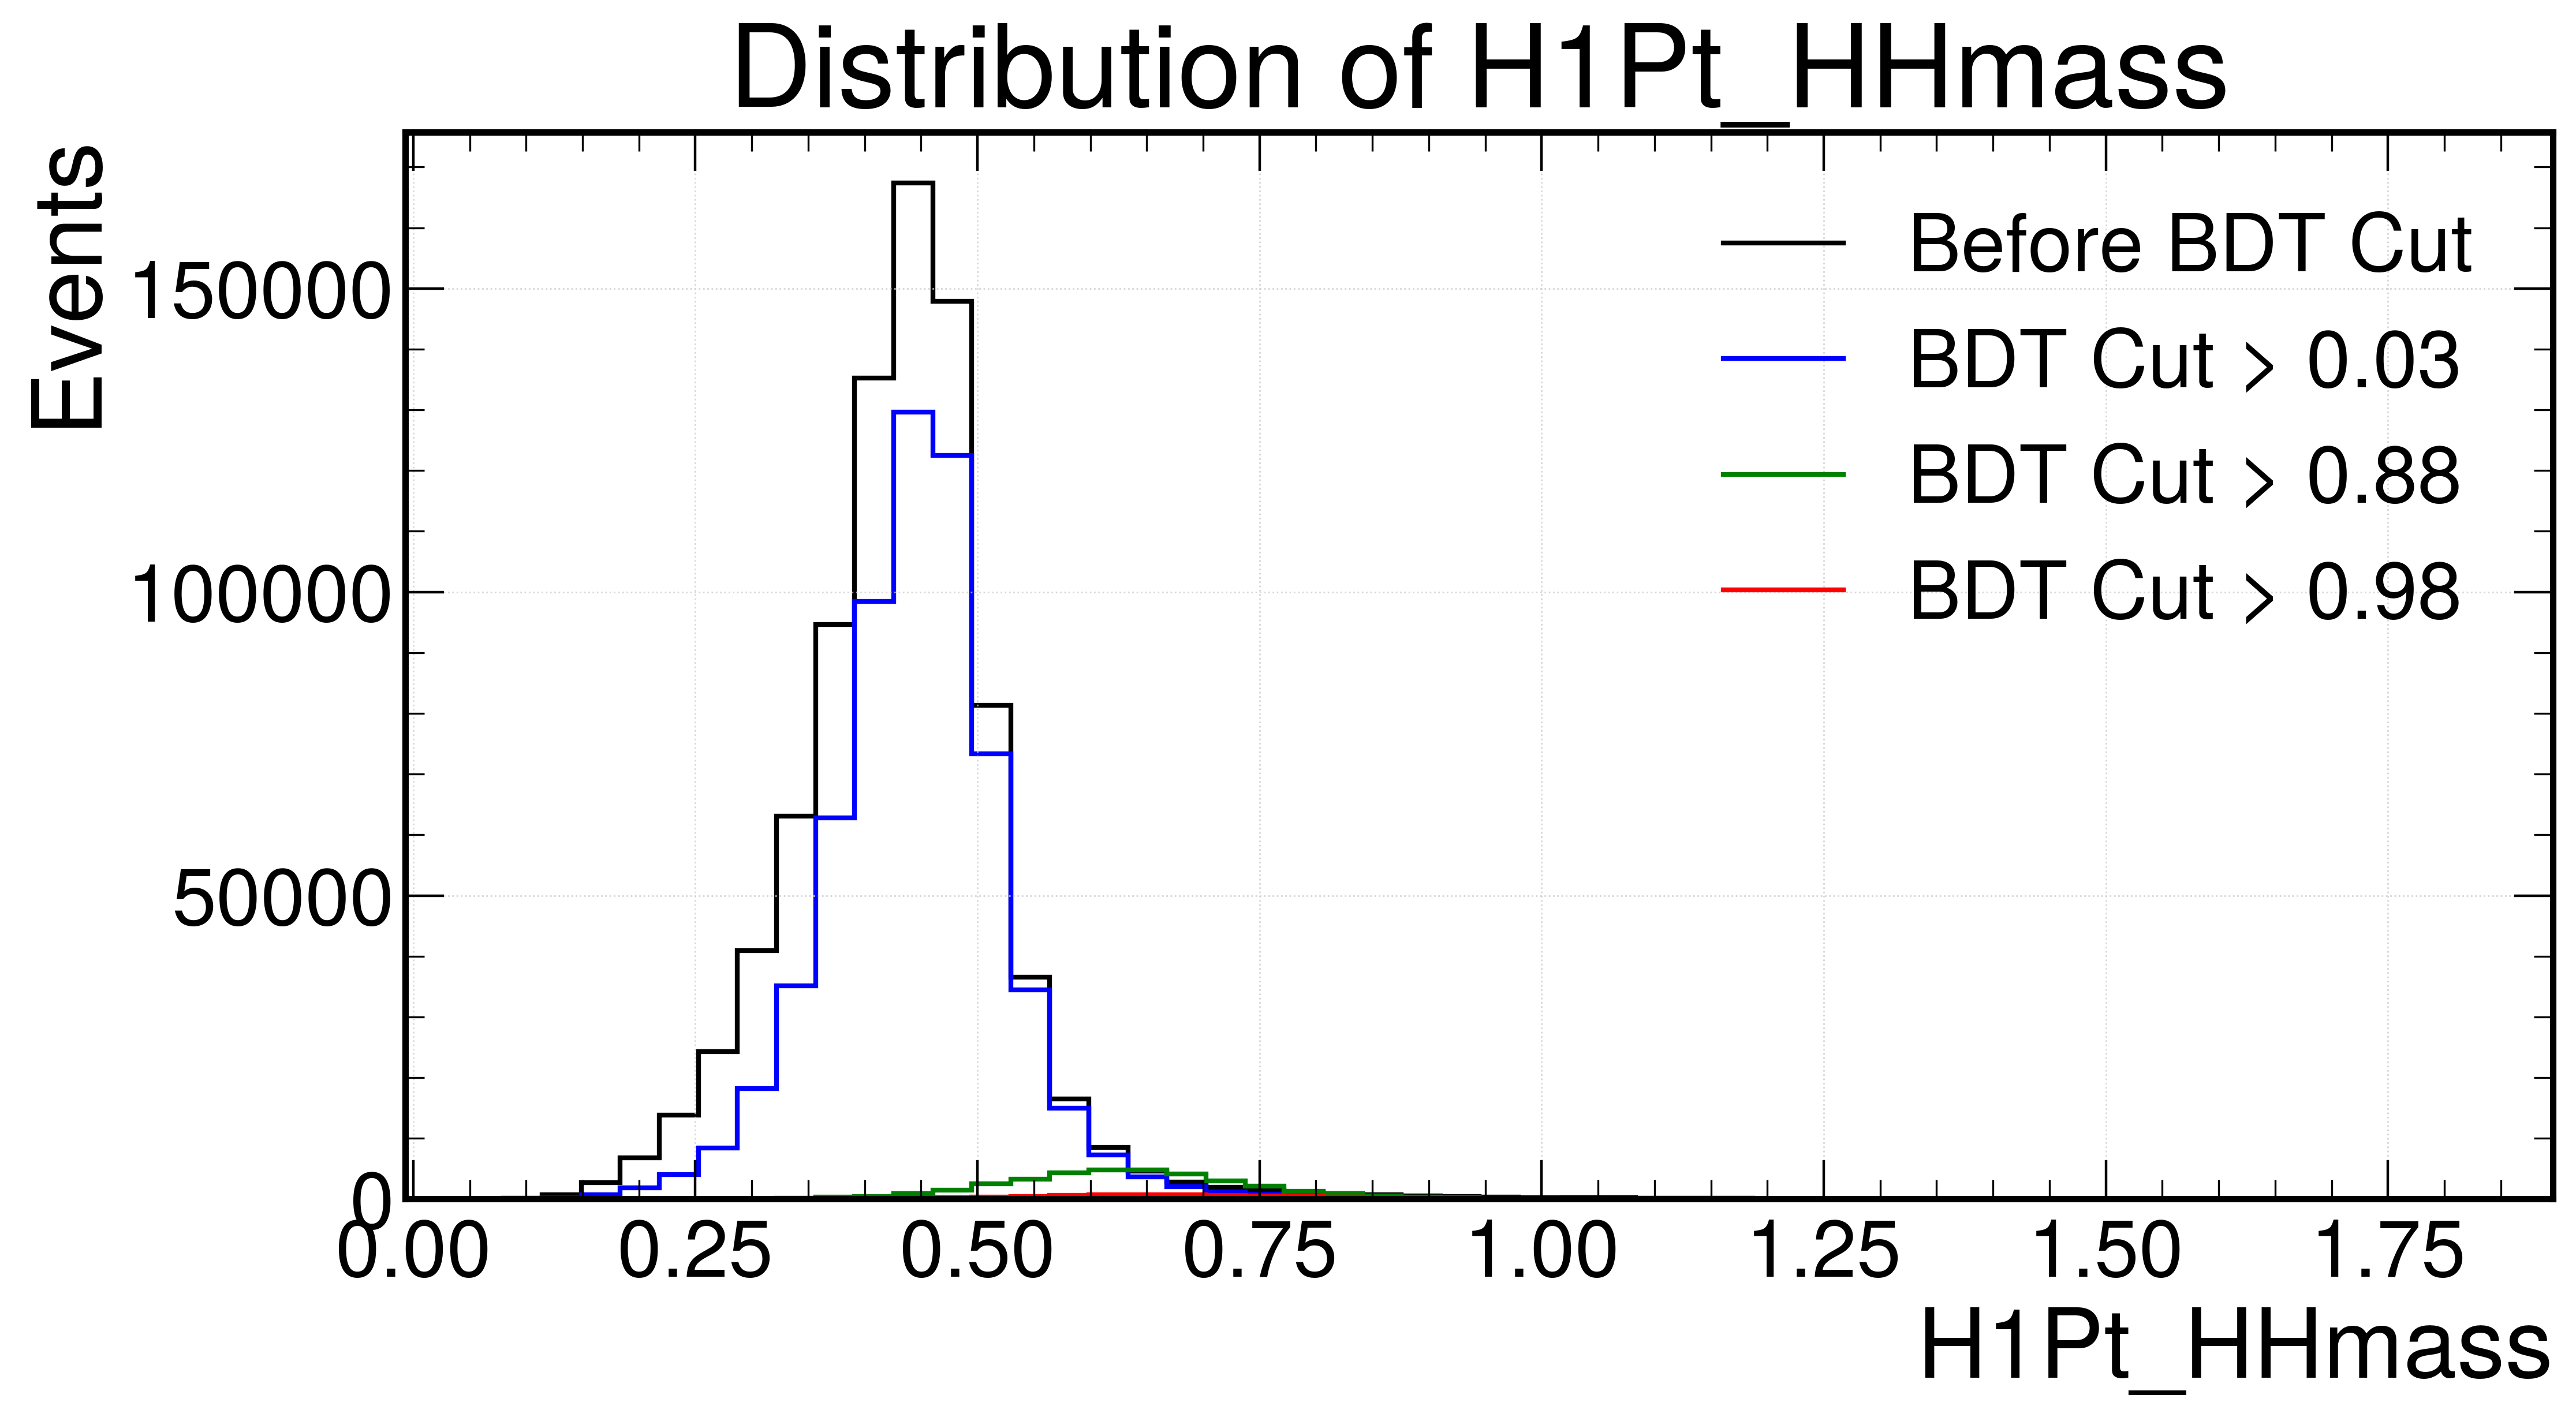

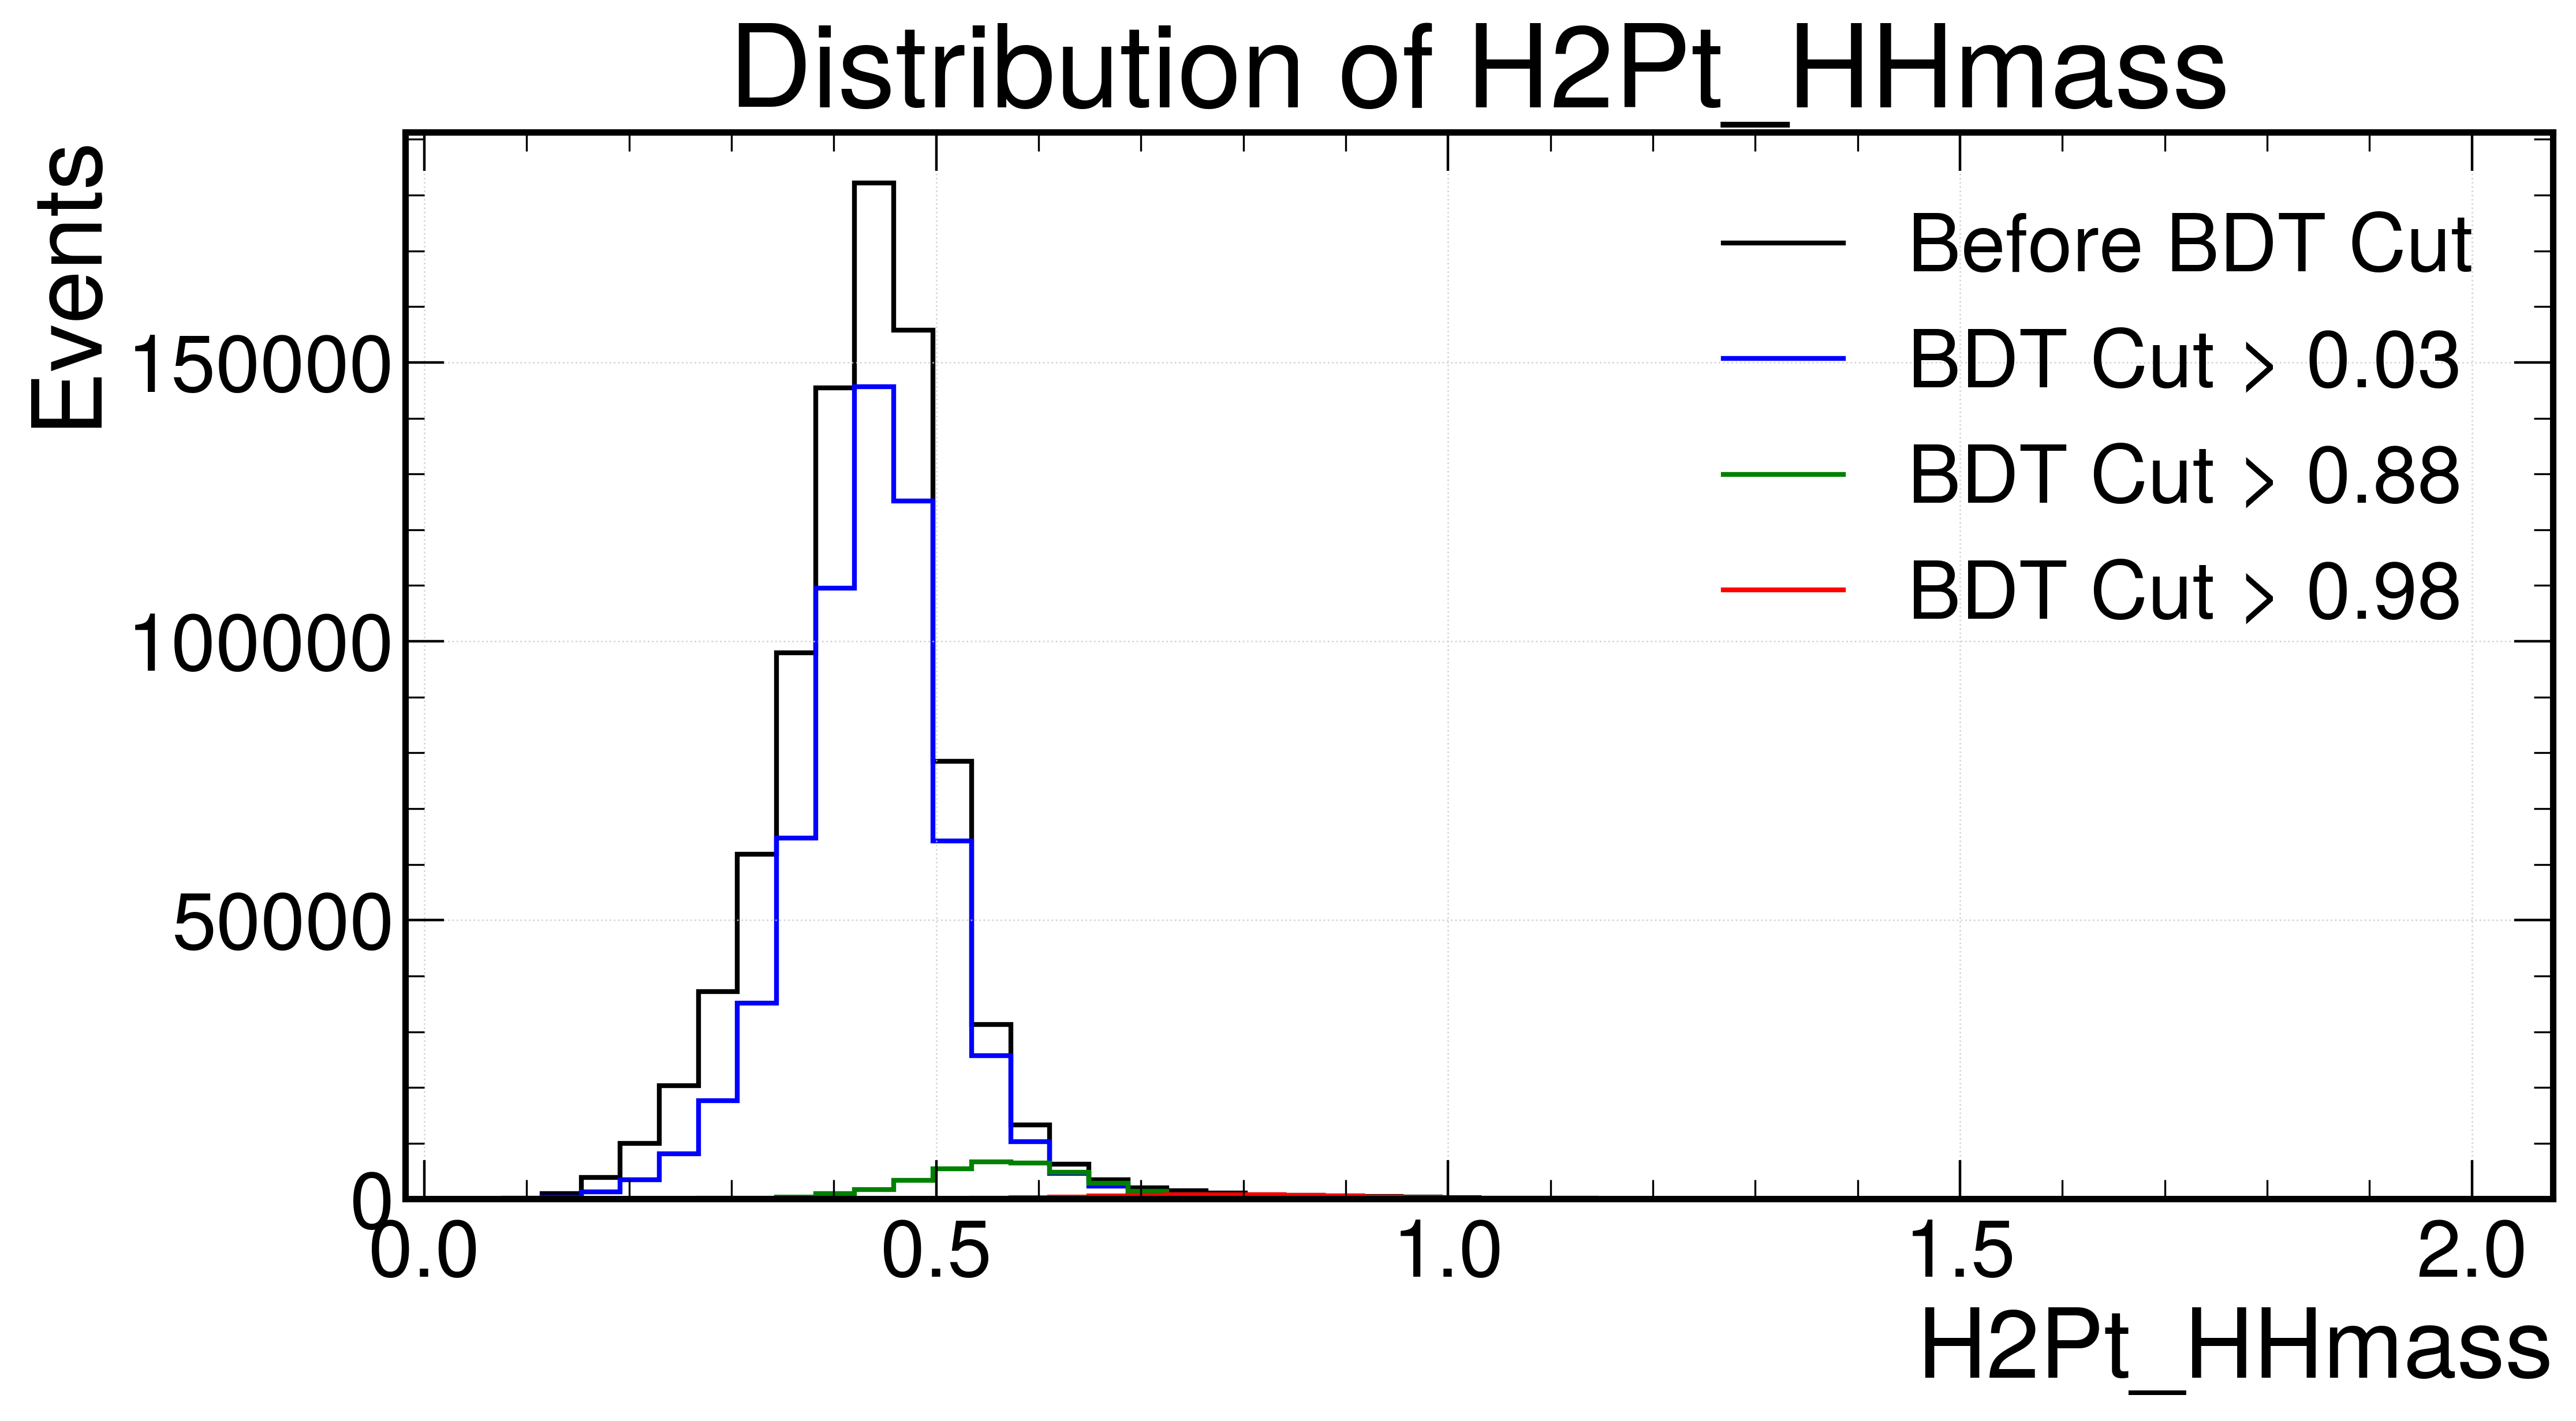

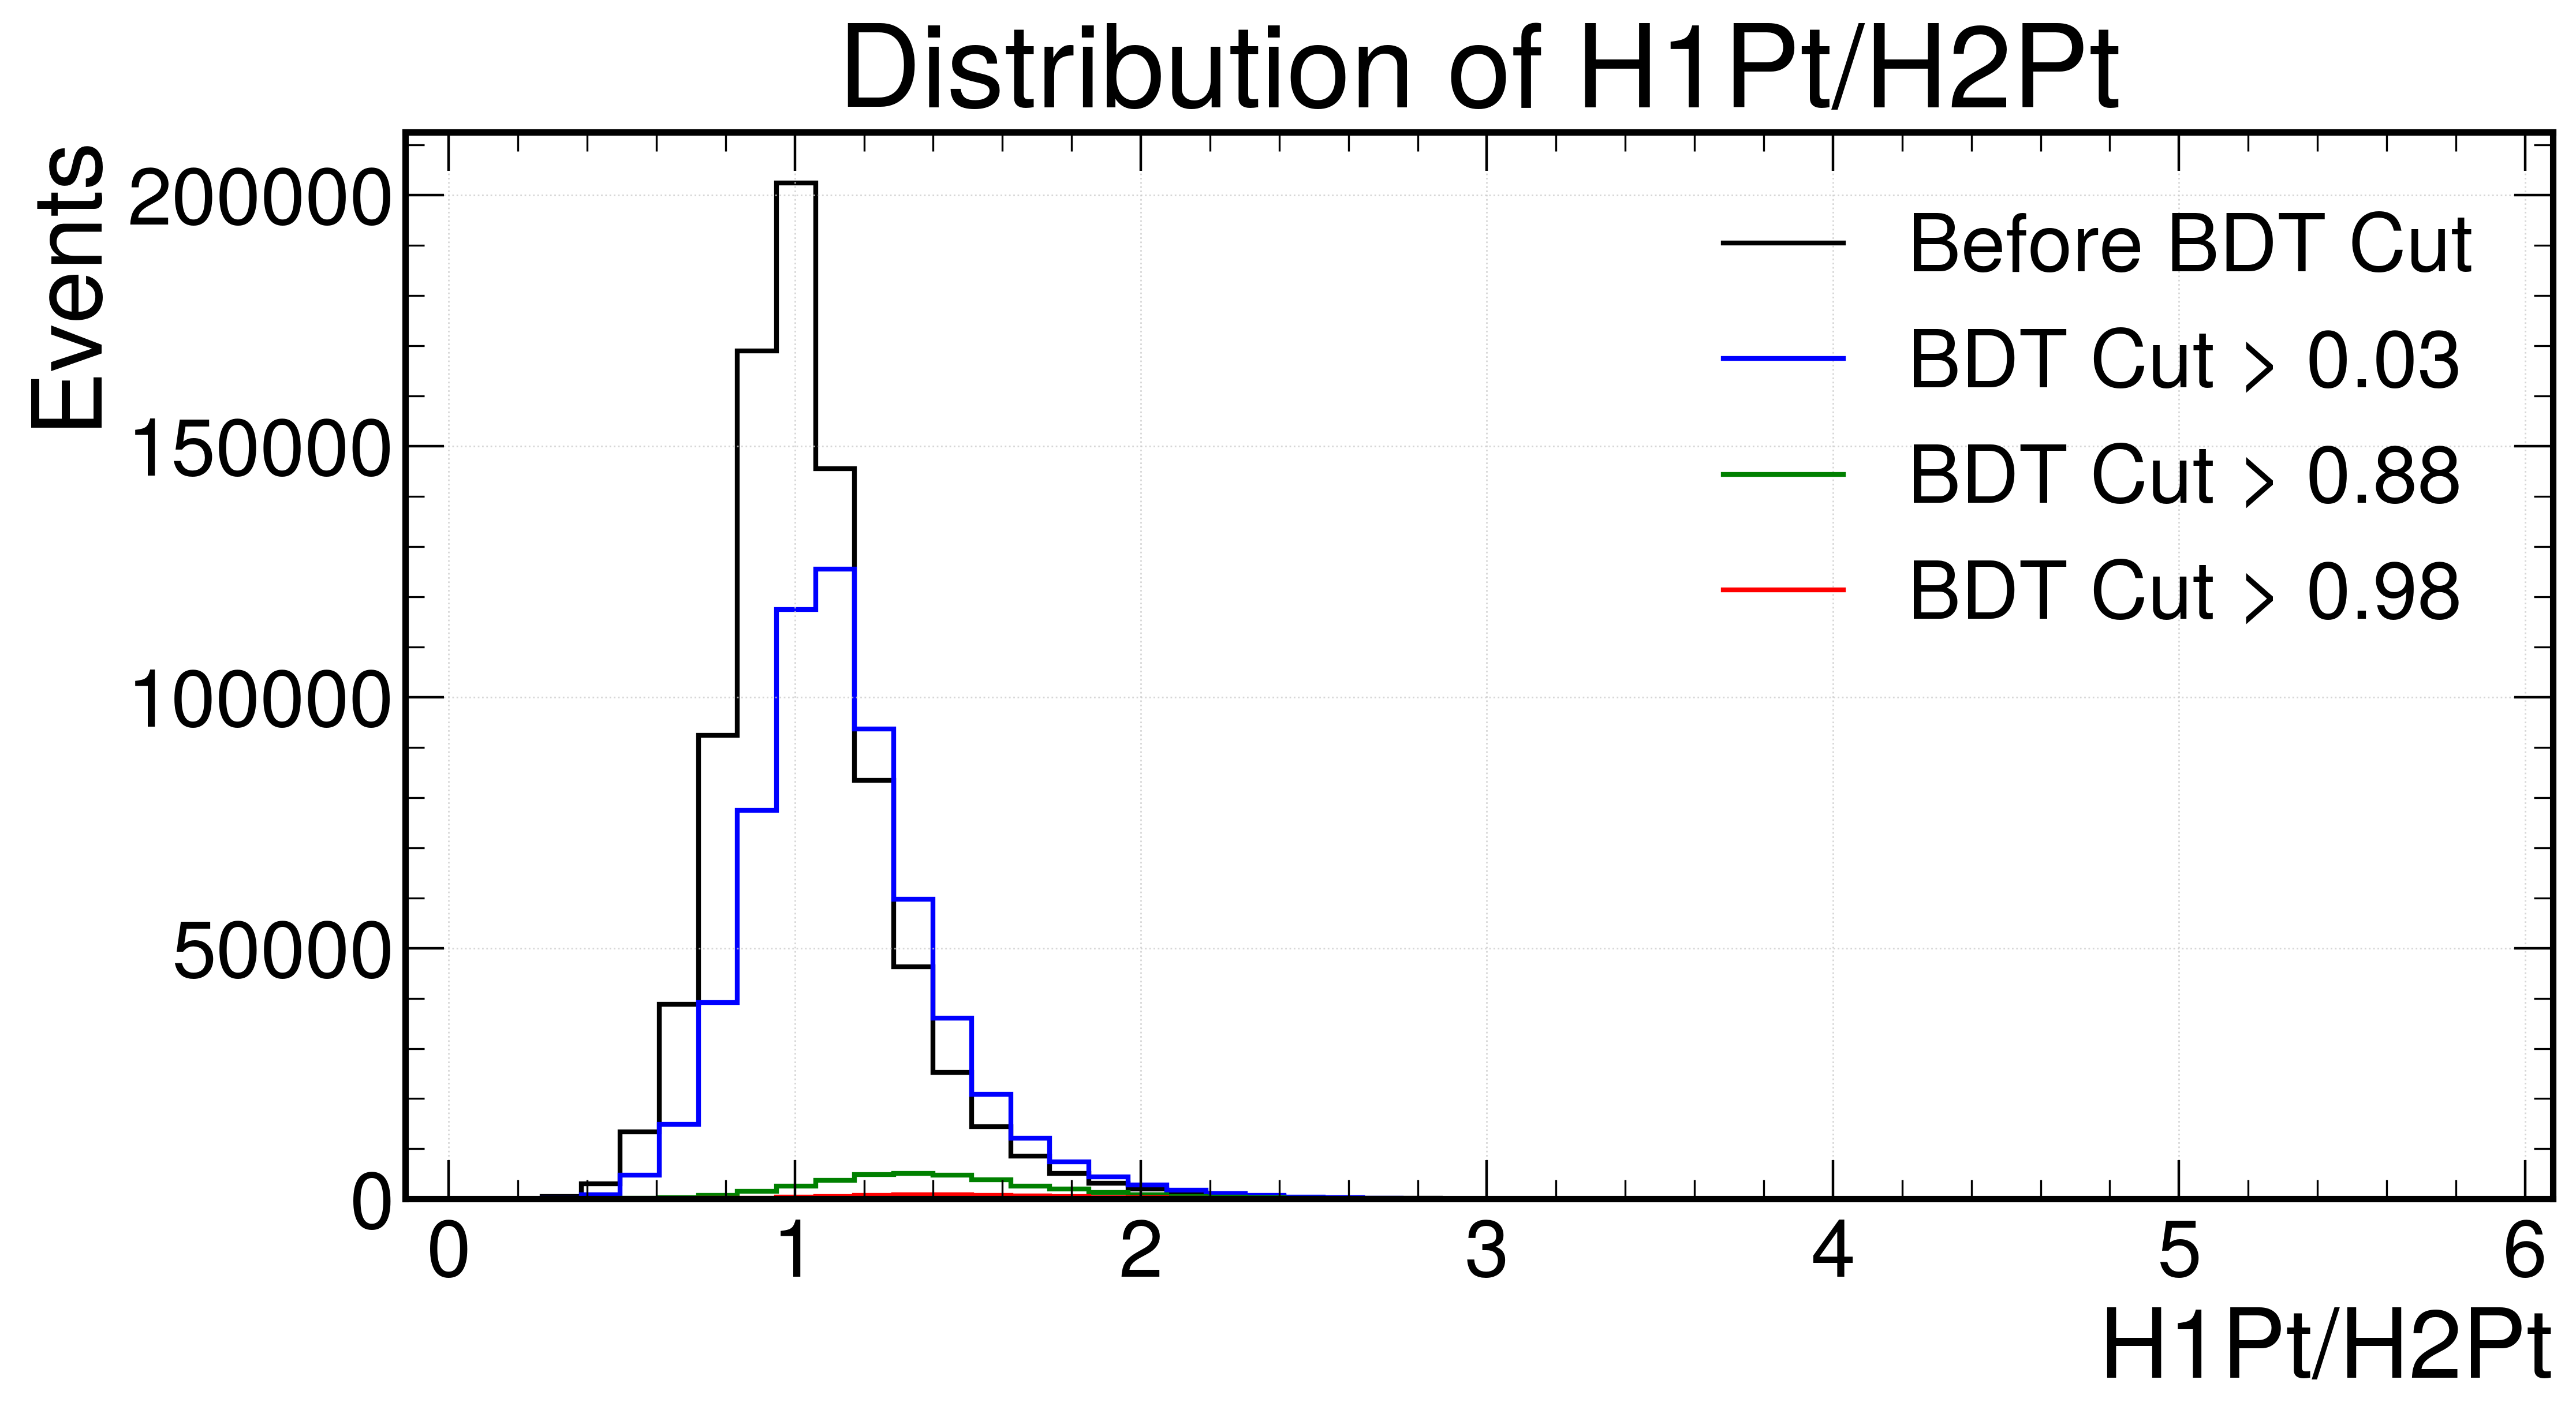

ValueError: autodetected range of [nan, nan] is not finite

<Figure size 4800x2400 with 0 Axes>

In [13]:
"""

Execute functions here 

"""

path_to_dir = "/home/users/dprimosc/data/24Sep25_v12v2_private_signal"
year = "2022"
jet_collection = "bbFatJet"
jet_index = 0
jet_coll_pnet = "PNetTXbbLegacy"
jet_coll_mass = "PNetMassLegacy"
"""
bdt_model = "v5_PNetLegacy"
bdt_config = "24May31_lr_0p02_md_8_AK4Away"
bdt_model_name = "24May31_lr_0p02_md_8_AK4Away"
"""
bdt_models = {
    "v5_PNetLegacy": {
        "config": "v5",
        "model_name": "24May31_lr_0p02_md_8_AK4Away",
    },
}


bdt_score, bdt_score_vbf, bdt_df = load_events_and_bdt(
    path_to_dir, year, jet_coll_pnet, jet_coll_mass, bdt_models
)

print(bdt_df.keys())
plot_bdt_features(bdt_score, bdt_score_vbf, bdt_df)